---

# **Análisis de series de tiempo univariadas**
# **Análisis descriptivo (Serie papa superior)**
## **Universidad Nacional de Colombia**
#### Michel Mendivenson Barragán Zabala
#### César Augusto Prieto Sarmiento
#### Cristián Camilo Prieto Zambrano
#### Rondón Vargas Andrés Fabián

---

In [1]:
library(dplyr)
library(forecast)
dir = '~/UN/4) Series de tiempo univariadas (STU)/2) Workplace/1) Data'
setwd(dir)

options(warn = -1)  # Desactiva advertencias
options(digits = 2)  # Desactiva mensajes


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



## 🥔 **Serie papa**

El **Sistema de Información de Precios y Abastecimientos del Sector Agropecuario (SIP-SA)**, gestionado por el Ministerio de Agricultura de Colombia recopila y ppublica datos diarios de precios de productos agrícolas (No solamente de las cosechas sino de productos de intéres para el productor). Estos precios, obtenidos mediante metodologías estandarizadas que incluyen encuestas a mayoristas y seguimiento de transacciones, permiten analizar tendencias y volatilidad en la cadena de suministro. Se pretende analizar la serie de tiempo del precio de la papa reportado por el SIPSA para explorar patrones estacionales, factores influyentes y proyecciones que aporten a la toma de decisiones en el sector agrícola, específicamente el precio por libra registrado en la central mayorista Corabastos. 
Los datos pueden ser encontrados [aquí](https://microdatos.dane.gov.co/index.php/catalog/776/get-microdata.). Para obtener datos con los que sea posible trabajar, se realizan ciertas operaciones primero:

- **Unir las diferentes bases de datos:** Los precios al consumidor están organizados mensualmente.

In [2]:
# =====> Reading the data
# The datasets are encoded in Latin1 format for unknown reasons and have some 
# extra ;;;; at the end of each line (That's why only columns 1 to 5 are selected)

data13 = read.csv2(file = 'Files/Mensual_2013_2017.csv', header = TRUE, sep = ';', 
                   fileEncoding = 'latin1', blank.lines.skip = TRUE)[,1:5]
data18 = read.csv2(file = 'Files/Mensual_2018.csv', header = TRUE, sep = ';', 
                   fileEncoding = 'latin1', blank.lines.skip = TRUE)[,1:5]
data19 = read.csv2(file = 'Files/Mensual_2019.csv', header = TRUE, sep = ';', 
                   fileEncoding = 'latin1', blank.lines.skip = TRUE)[,1:5]
data20 = read.csv2(file = 'Files/Mensual_2020.csv', header = TRUE, sep = ';', 
                   fileEncoding = 'latin1', blank.lines.skip = TRUE)[,1:5]
data21 = read.csv2(file = 'Files/Mensual_2021.csv', header = TRUE, sep = ';', 
                   fileEncoding = 'latin1', blank.lines.skip = TRUE)[,1:5]
data22 = read.csv2(file = 'Files/mensual 22.csv', header = TRUE, sep = ';', 
                   fileEncoding = 'latin1', blank.lines.skip = TRUE)[,1:5]
data23 = read.csv2(file = 'Files/mensual 23.csv', header = TRUE, sep = ';', 
                   fileEncoding = 'latin1', blank.lines.skip = TRUE)[,1:5]

# =====> Rowbind all the datasets 
# Since each dataset has the same columns, it’s straightforward to row-bind 
# them all to have the data in a single dataframe.
dataset = list(data13, data18, data19, data20, data21, data22, data23)
data = NA
for (i in dataset){
  colnames(i) = colnames(data13)       # Unfortunately, not all datasets have the same column names
  data = rbind(data, i)
}
rm(list = setdiff(ls(), 'data'))

- **Filtrar sólo el precio de la papa en Corabastos:** La base de datos está conformada por precios de múltiples productos en múltiples centrales mayoristas.

In [3]:
data = data %>% 
  filter(stringr::str_detect(Producto, "Papa ") & Fuente == "Bogotá, D.C., Corabastos") %>% 
  mutate(Precio = as.integer(gsub(pattern = '\\.', x = Precio, replacement = ''))) %>% 
  select(-Grupo) # The Group variable in no longer needed

data |> tail()

,Fecha,Producto,Fuente,Precio
,<chr>,<chr>,<chr>,<int>
1256,dic-23,Papa rubí,"Bogotá, D.C., Corabastos",1418
1257,dic-23,Papa R-12 negra,"Bogotá, D.C., Corabastos",1666
1258,dic-23,Papa R-12 roja,"Bogotá, D.C., Corabastos",1533
1259,dic-23,Papa sabanera,"Bogotá, D.C., Corabastos",3250
1260,dic-23,Papa superior,"Bogotá, D.C., Corabastos",1811
1261,dic-23,Papa única,"Bogotá, D.C., Corabastos",1430


- **Guardando todas las series:** Hay series incompletas

In [7]:
TimeSeries <- data |> 
  filter(Producto == unique(Producto)[1]) |> 
  select(Fecha, Precio) 
colnames(TimeSeries) <- c('Fecha', as.character(unique(data$Producto)[1]))

for (i in unique(data$Producto)[-1]) {
  # Filtra el producto actual y renombra la columna de precios
  product_data <- data |> 
    filter(Producto == i) |> 
    select(Fecha, Precio)
  
  colnames(product_data) <- c('Fecha', as.character(i))
  
  # Une los datos con TimeSeries usando full_join para mantener todas las fechas
  TimeSeries <- TimeSeries |> 
    full_join(product_data, by = 'Fecha')
}
TimeSeries = ts(TimeSeries[,-1], start = 2013, freq = 12)

Luego del proceso de filtrado, limpieza y revisión de los datos se obtienen las siguientes series de tiempo:

> Las series de las papas de variedades R-12 negra, R-12 roja, suprema, rubí y betina tienen pocas observaciones. Y la variedad de papa superior cuenta con observaciones unicamente desde el año 2014.

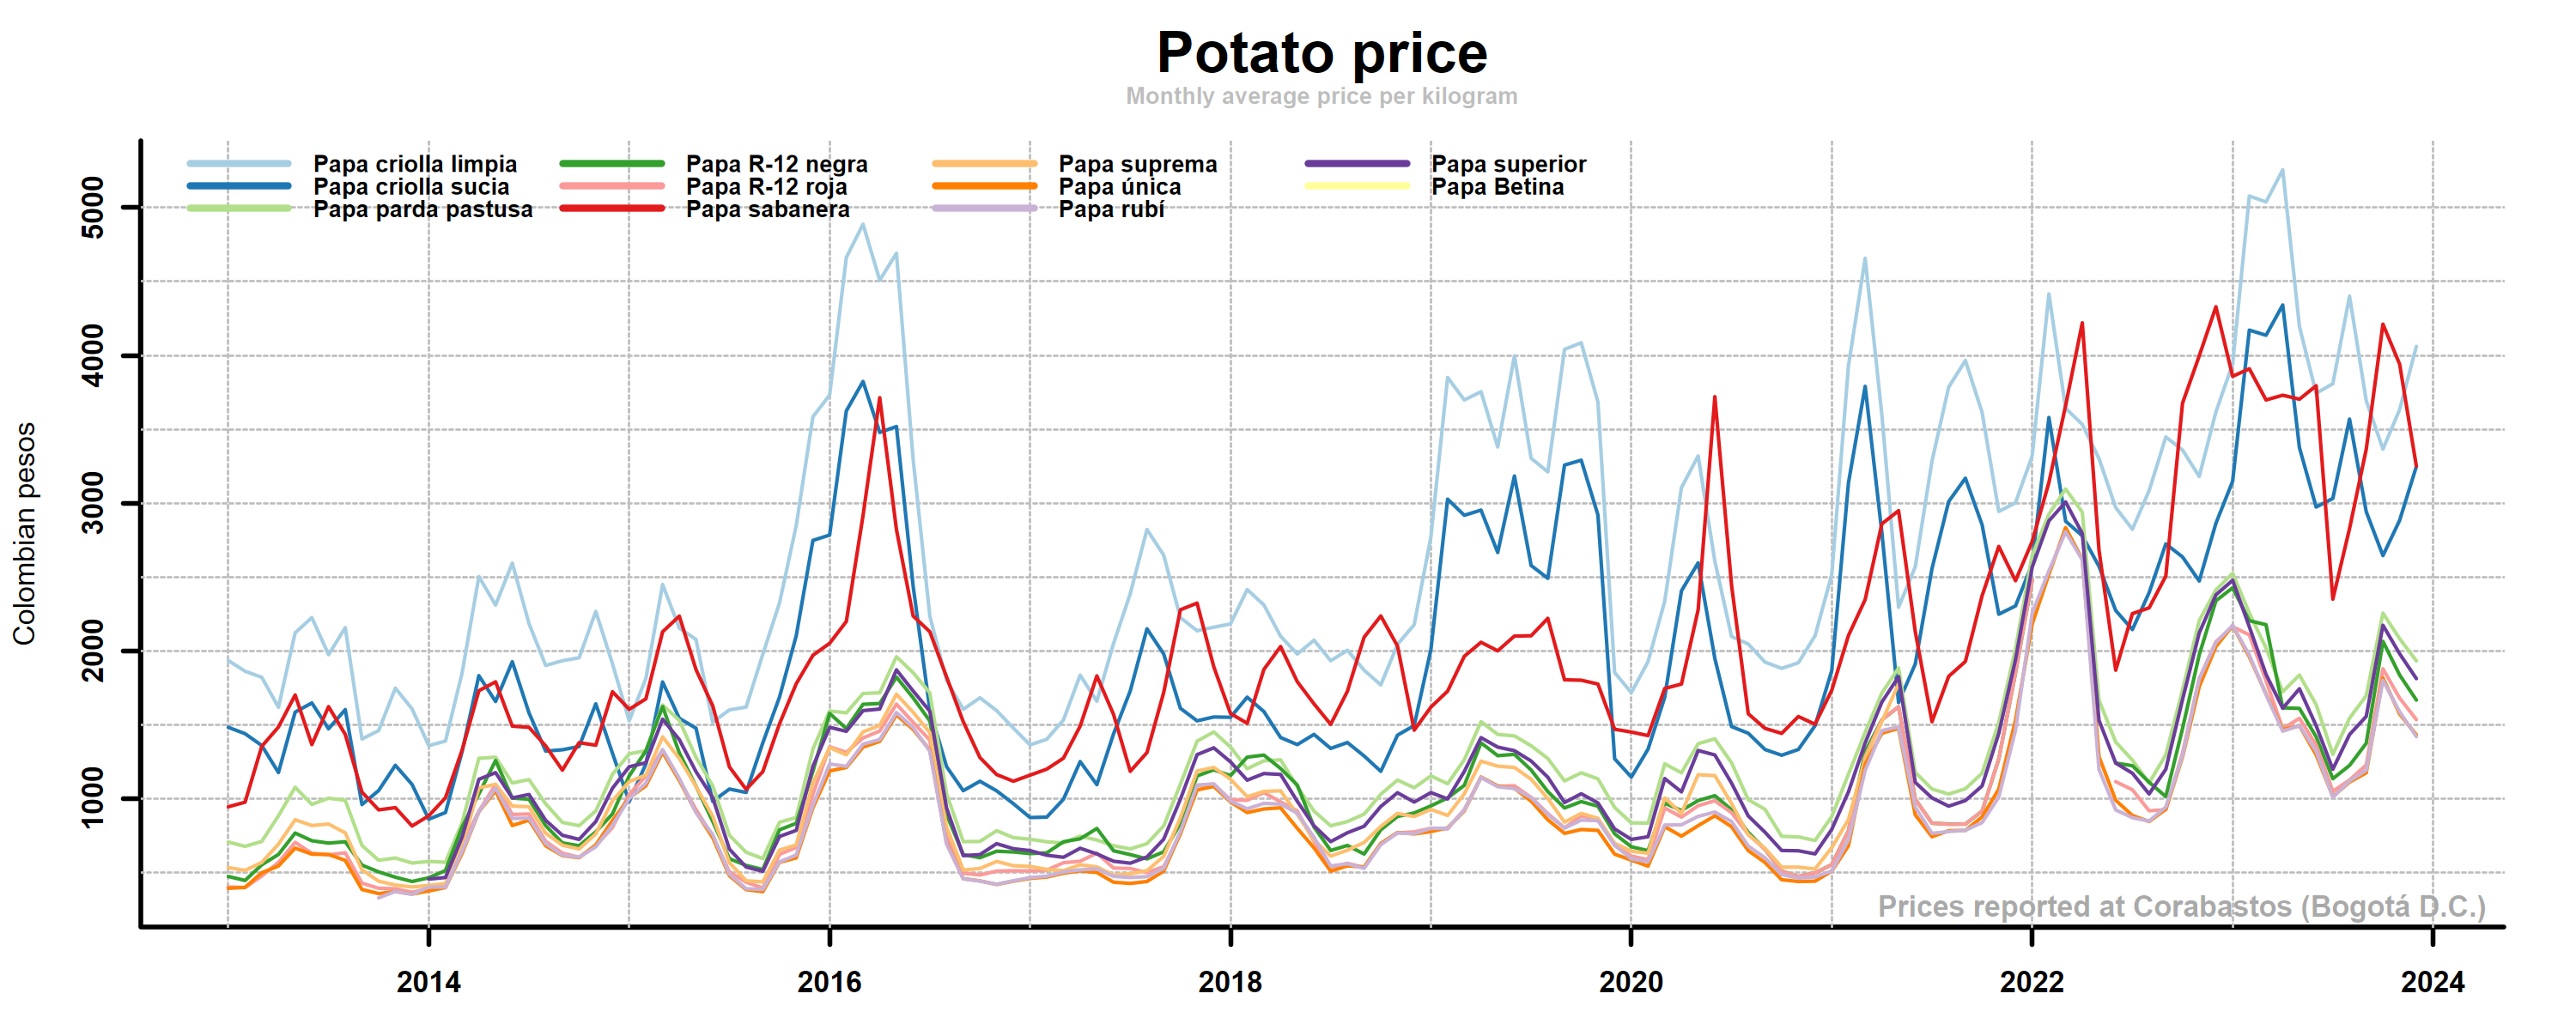

In [8]:
options(repr.plot.width = 15)  # Establece el ancho del gráfico a 10 pulgadas
options(repr.plot.height = 6)  # Opcional: ajusta la altura del gráfico
options(repr.plot.res = 200)

par(mar = c(3, 4.1, 4.1, 2.1))
colores <- RColorBrewer::brewer.pal(n = 11, name = 'Paired')
plot(TimeSeries, col = colores, plot.type = 'single', ylab = 'Colombian pesos', xlab = NA, type = "n",
     bty = 'n', axes = F, font.lab = 2)
title(main = 'Potato price', cex.main = 2, line = 2)
axis(1, lwd = 2, font = 2); axis(2, lwd = 2, font = 2); box(bty = 'l', lwd = 2)
abline(v = 2013:2024, col = 'gray', lty = 'dashed')                       # Reference lines
abline(h = seq(0, 5000, by = 500), col = 'gray', lty = 'dashed')

for (i in 1:ncol(TimeSeries)) {
  lines(TimeSeries[, i], col = colores[i], lwd = 1.5)                     # Plotting all the series
}

legend(x = 'topleft', x.intersp = 0.5, y.intersp = 1,
       # Position, space between legend items in x and y
       bty = 'n', col = colores, lty = 'solid', text.font = 2, lwd = 3,
       # Remove legend box, set colors and line type
       ncol = 4, cex = 0.8, legend = colnames(TimeSeries), 
       text.width = 1)

mtext(bquote(bold('Monthly average price per kilogram')), side = 3,
      col = 'gray', line = 0.8, cex = 0.8)
mtext('Prices reported at Corabastos (Bogotá D.C.)', side = 1,
      line = -1.2, cex = 1, adj = 0.99, col = 'darkgray', font = 2)

**De estas variedades, si bien es posible realizar un modelamiento de todas las series simultáneamente, se decide simular solamente la serie relacionada con el precio de la papa de la variedad superior.**

> **¿POR QUÉ?**

Del mismo modo que Corabastos se escogió por ser la central mayorista que recibe el mayor volumen de papa proveniente de Cundinamarca de todo el país (70% aprox.), la papa de variedad superior ha sido la variedad de predominancia en Cundinamarca según el [boletín regional](https://repositorio.fedepapa.com/bitstream/handle/20.500.14460/117/Regional-Cundinamarca.pdf?sequence=1&isAllowed=y) realizado por Fedepapa con fecha 15 de Octubre de 2023.

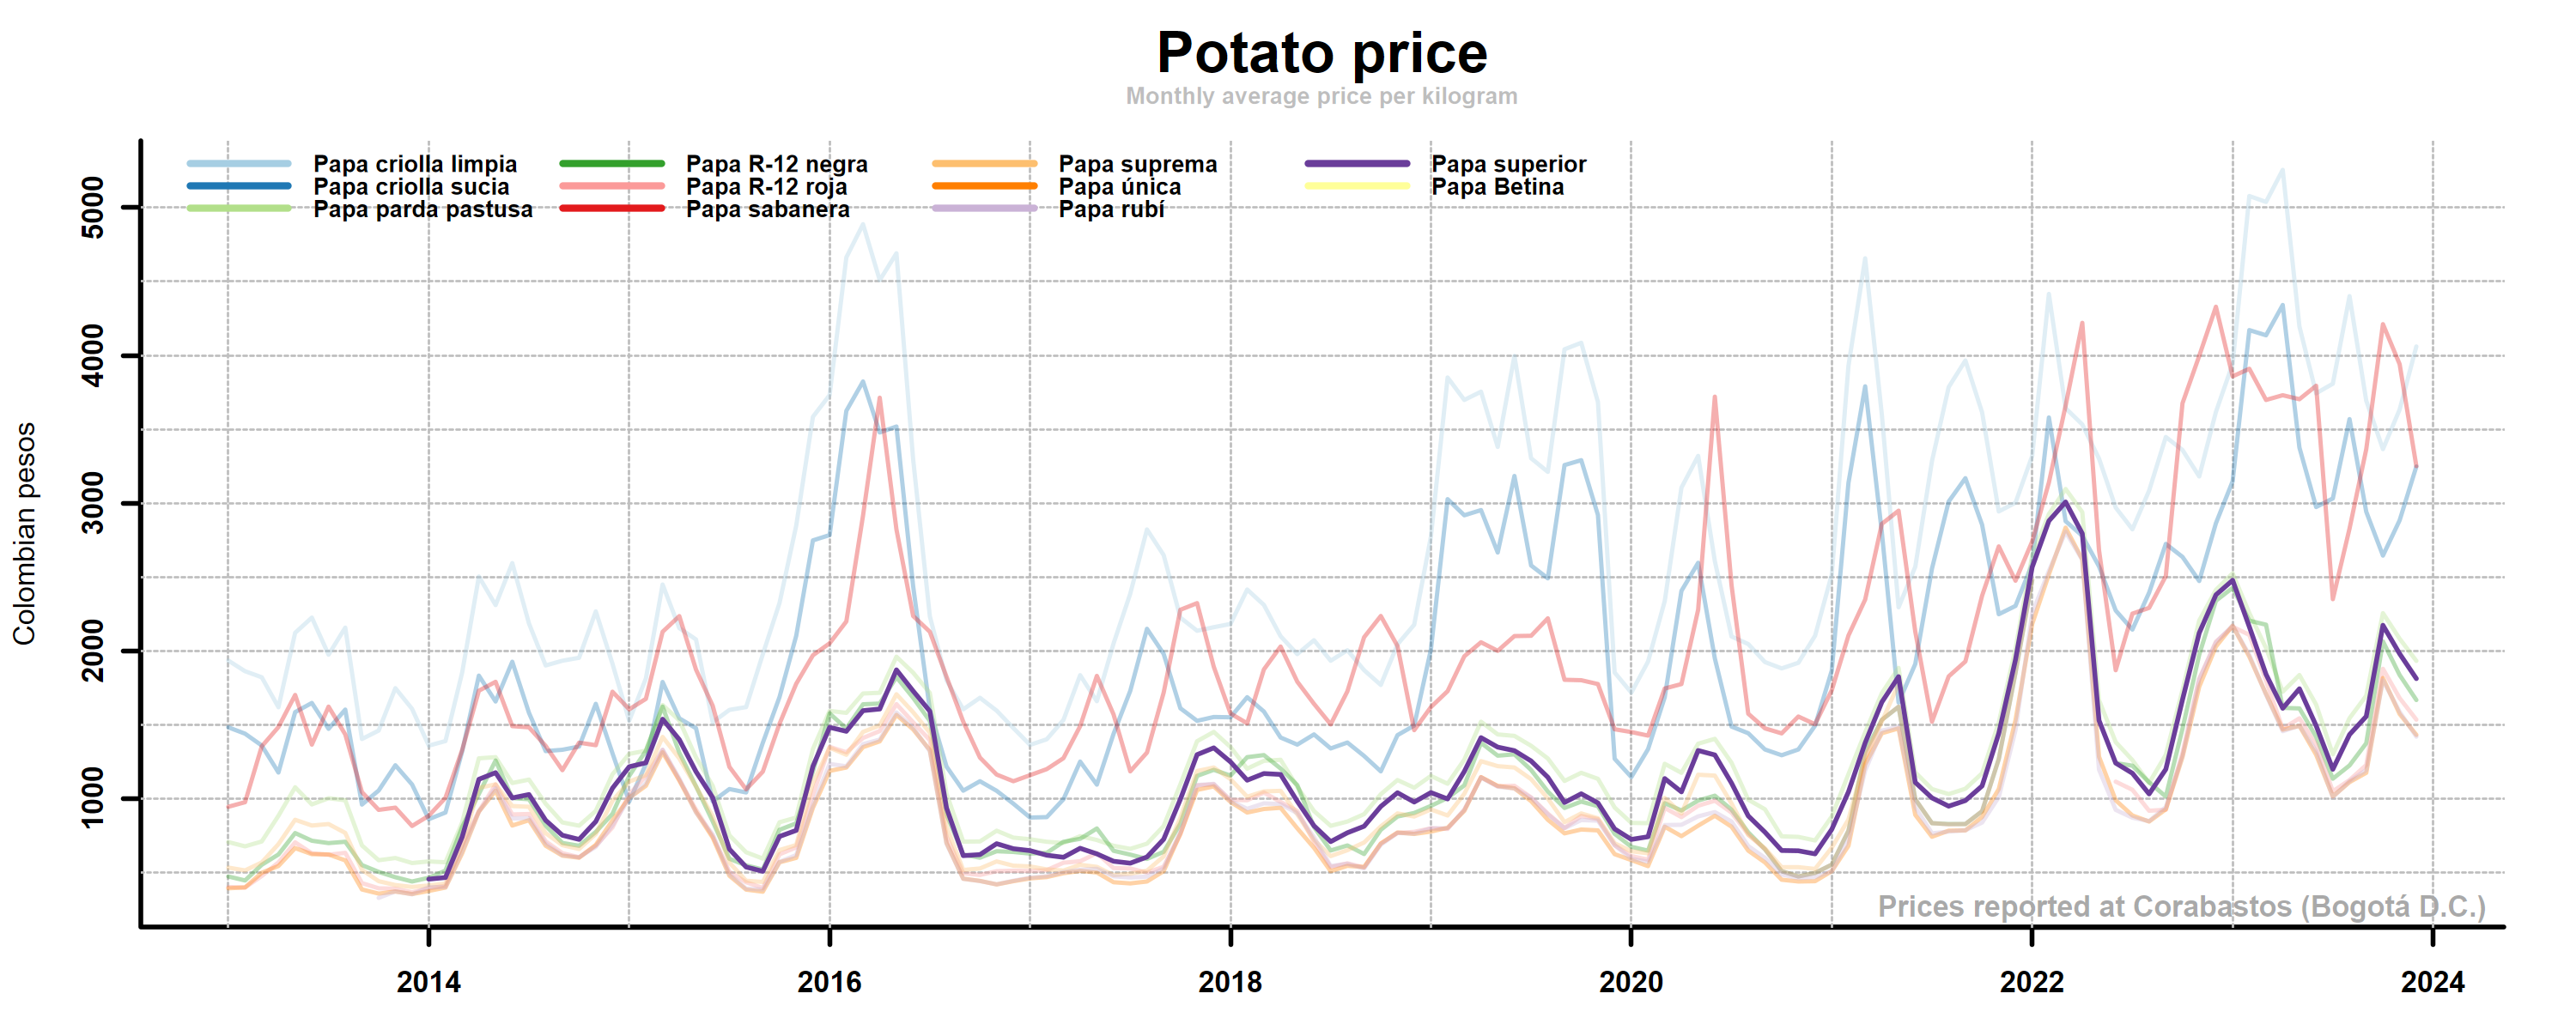

In [9]:
par(mar = c(3, 4.1, 4.1, 2.1))
plot(TimeSeries, col = colores, plot.type = 'single', ylab = 'Colombian pesos', xlab = NA, type = "n",
     bty = 'n', axes = F, font.lab = 2)
title(main = 'Potato price', cex.main = 2, line = 2)
axis(1, lwd = 2, font = 2); axis(2, lwd = 2, font = 2); box(bty = 'l', lwd = 2)
abline(v = 2013:2024, col = 'gray', lty = 'dashed')                       # Reference lines
abline(h = seq(0, 5000, by = 500), col = 'gray', lty = 'dashed')

for (i in 1:ncol(TimeSeries)) {
  lines(TimeSeries[, i], col = ifelse(i != 10, adjustcolor(colores[i], 0.35), colores[i]),
        lwd = ifelse(i != 10, 1.8, 2))                     # Plotting all the series
}

legend(x = 'topleft', x.intersp = 0.5, y.intersp = 1,
       # Position, space between legend items in x and y
       bty = 'n', col = colores, lty = 'solid', text.font = 2, lwd = 3,
       # Remove legend box, set colors and line type
       ncol = 4, cex = 0.8, legend = colnames(TimeSeries), 
       text.width = 1)

mtext(bquote(bold('Monthly average price per kilogram')), side = 3,
      col = 'gray', line = 0.8, cex = 0.8)
mtext('Prices reported at Corabastos (Bogotá D.C.)', side = 1,
      line = -1.2, cex = 1, adj = 0.99, col = 'darkgray', font = 2)

In [10]:
papa = TimeSeries[,'Papa superior']
papa = papa[!is.na(papa)]

## *1️⃣ HOMOCEDASTICIDAD:*

La serie entre 2017 y 2021 tiene una variación diferente tanto en relación con los períodos anteriores o posteriores a estas fechas.

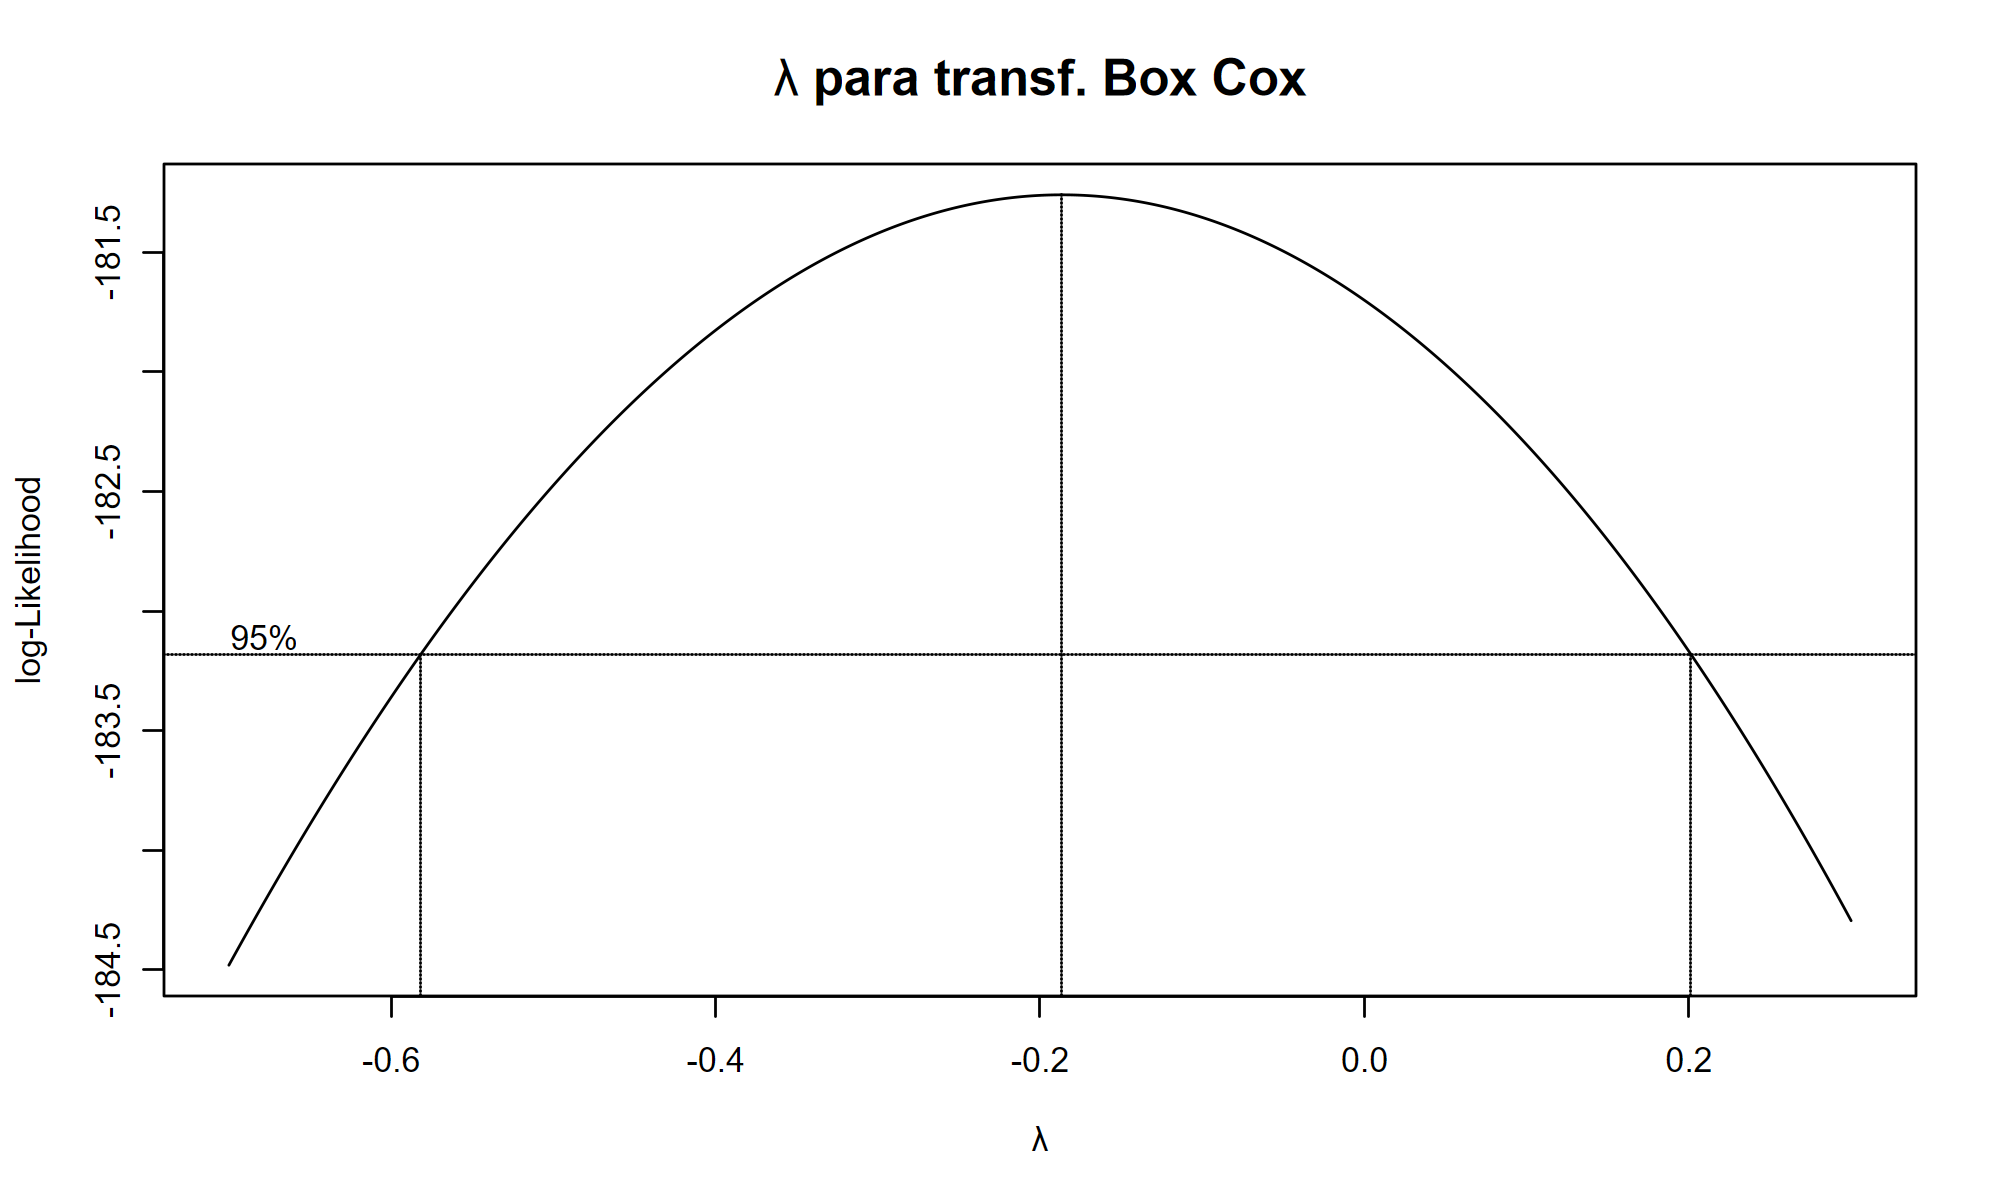

In [16]:
options(repr.plot.width = 10)  # Establece el ancho del gráfico a 10 pulgadas
options(repr.plot.height = 6)  # Opcional: ajusta la altura del gráfico
options(repr.plot.res = 200)

MASS::boxcox(lm(papa~1), seq(-0.7,0.3, length = 1000))
title(main = latex2exp::TeX('$\\lambda$ para transf. Box Cox', bold = T), cex.main = 1.5)

In [17]:
forecast::BoxCox.lambda(papa,method = 'loglik')

[1] -0.1

Se utilizará la transformación logaritmo natural para estabilizar la varianza:

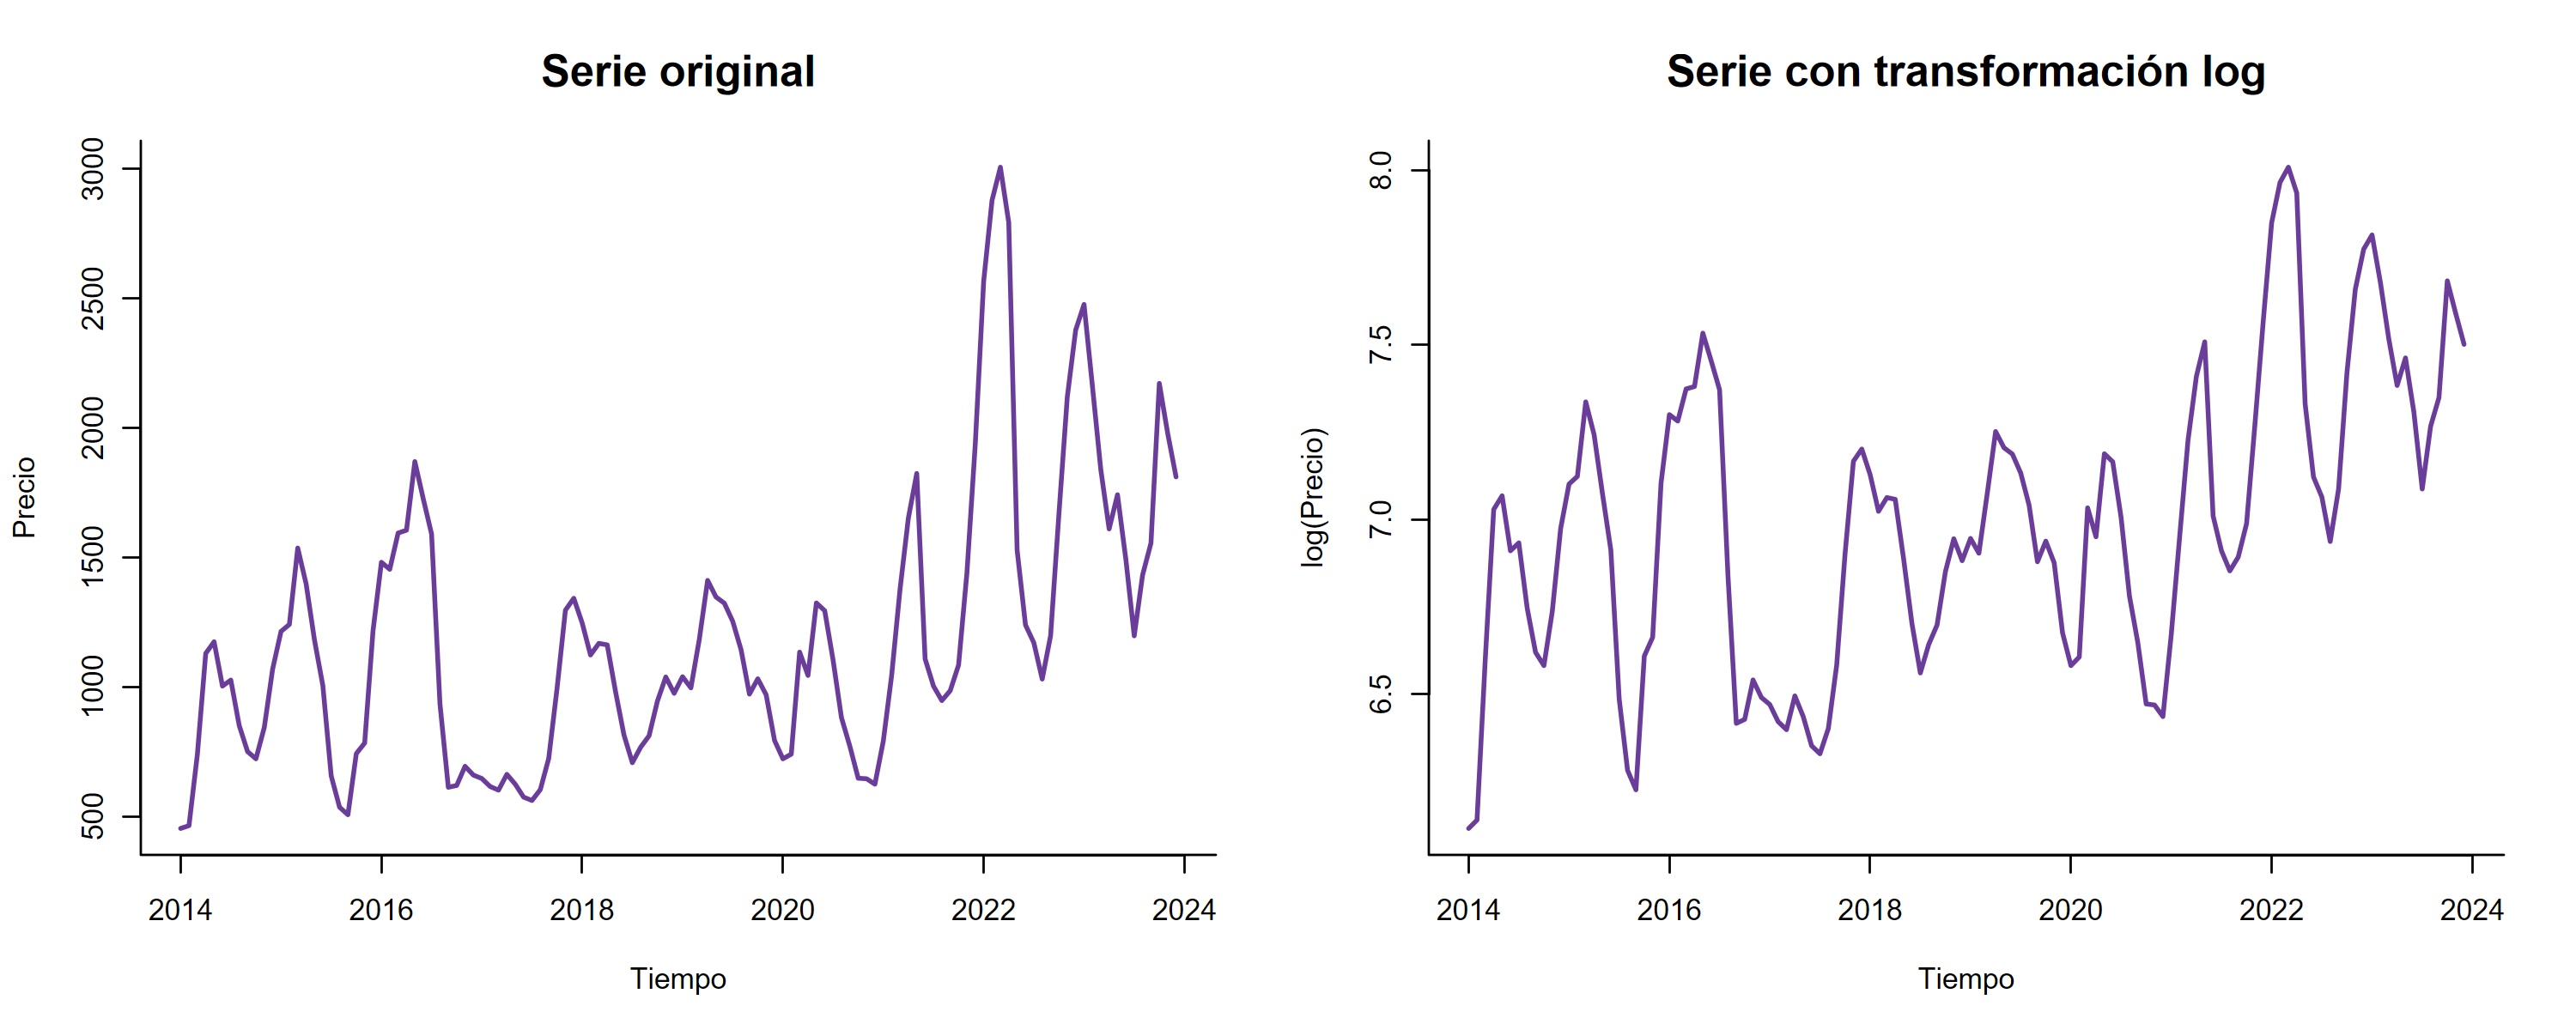

In [19]:
papa = ts(papa, start = c(2014,1), frequency = 12)

options(repr.plot.width = 15)  # Establece el ancho del gráfico a 10 pulgadas
options(repr.plot.height = 6)  # Opcional: ajusta la altura del gráfico
options(repr.plot.res = 200)

color = colores[10]
par(mfrow = c(1,2))
plot(papa, ylab = 'Precio', xlab = 'Tiempo', lwd = 2, bty = 'l',
    main = 'Serie original', cex.main = 1.5, col = color)
plot(log(papa), ylab = 'log(Precio)', xlab = 'Tiempo', lwd = 2, bty = 'l',
    main = 'Serie con transformación log', cex.main = 1.5, col = color)

Por lo que nos quedamos con la serie transformada con logaritmo:

In [20]:
forecast::BoxCox.lambda(log(papa))

[1] 0.22

In [21]:
papa_l = log(papa)

> El objeto `papa` corresponde con la serie original mientras que los objetos `papa_**` se corresponderán con las series transformadas donde `**` serán reemplazados por letras que representen la transformación o transformaciones realizadas a la serie.

## *2️⃣ TENDENCIA*

La serie luego de ser transformada parece exhibir una pequeña tendencia al alza a lo largo de los años, por lo que se decide intentar eliminar esta tendencia con una diferencia regular en un paso:

In [22]:
tseries::adf.test(papa_l)
tseries::kpss.test(papa_l)
tseries::pp.test(papa_l)


	Augmented Dickey-Fuller Test

data:  papa_l
Dickey-Fuller = -4, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary



	KPSS Test for Level Stationarity

data:  papa_l
KPSS Level = 0.9, Truncation lag parameter = 4, p-value = 0.01



	Phillips-Perron Unit Root Test

data:  papa_l
Dickey-Fuller Z(alpha) = -31, Truncation lag parameter = 4, p-value =
0.01
alternative hypothesis: stationary


In [23]:
ndiffs(papa_l)

[1] 1

In [24]:
primero = papa_l[1]
primero

[1] 6.1

In [26]:
papa_ld = diff(papa_l)

In [27]:
ndiffs(papa_ld)

[1] 0

Si bien la tendencia no parece uy marcada igual y parece existir cierta tendencia. Apoyados con la prueba de `ndiffs()` podemos decir que existe cierta tendencia, si ajustamos una regresión LOESS es más sencillo ver la tendencia.

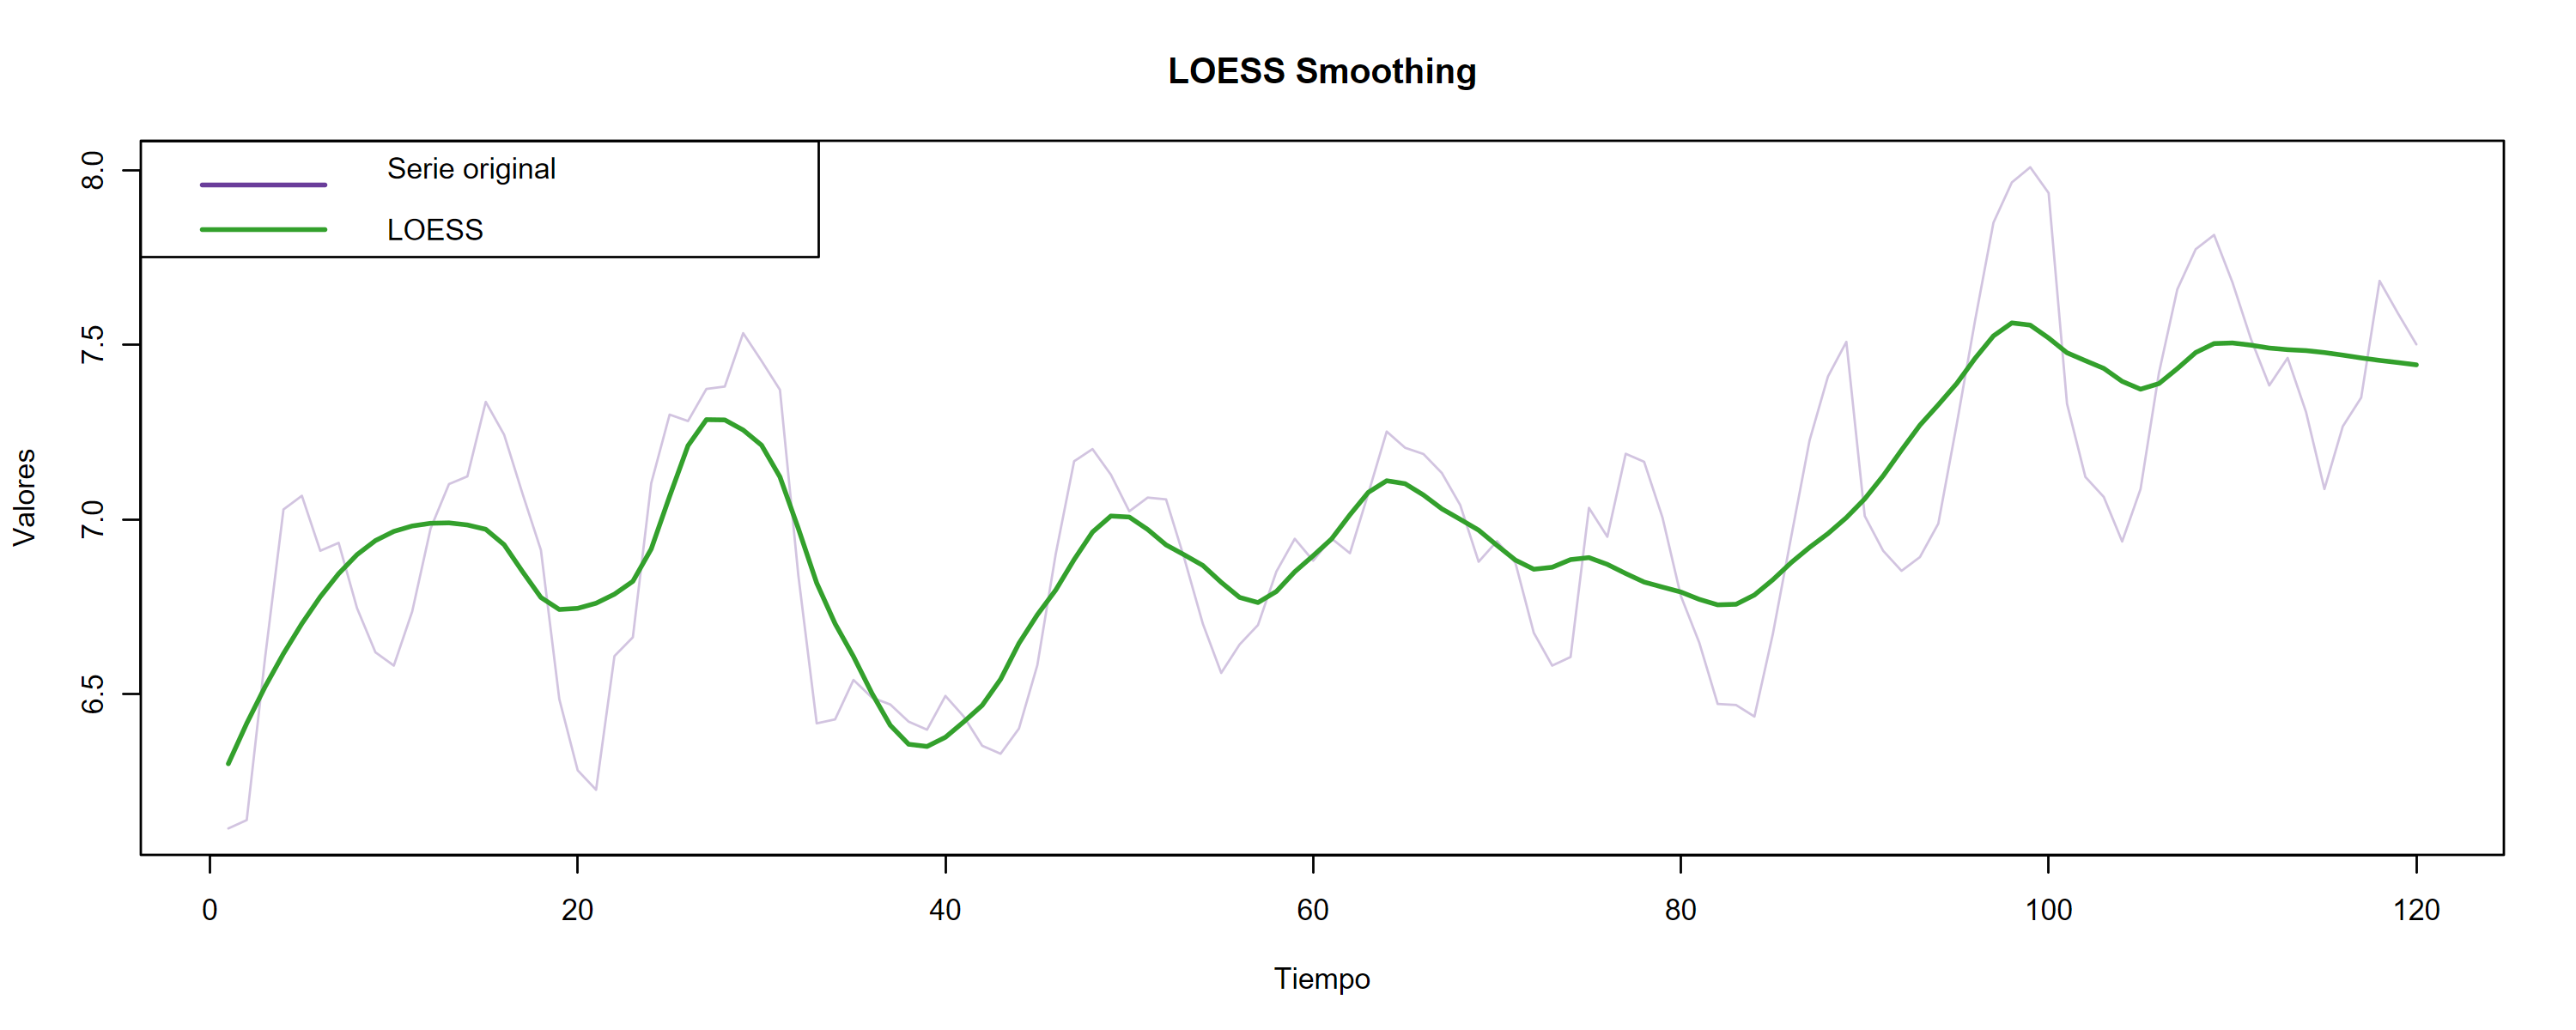

In [28]:
x <- 1:120  # Índice de tiempo (1, 2, 3, ..., 120)
loess_model <- loess(papa_l ~ x, span = 0.2)  # span controla el suavizado

# Predecir los valores suavizados
y_smooth <- predict(loess_model)

# Graficar la serie original y el LOESS ajustado
plot(x, papa_l, type = "l", col = adjustcolor(color, 0.3), main = "LOESS Smoothing", xlab = "Tiempo", ylab = "Valores")
lines(x, y_smooth, col = colores[4], lwd = 2)
legend("topleft", legend = c("Serie original\n", "LOESS"), col = c(color, colores[4]), lwd = 2)

Además, también es posible ver esta tendencia en el ACF y PACF:

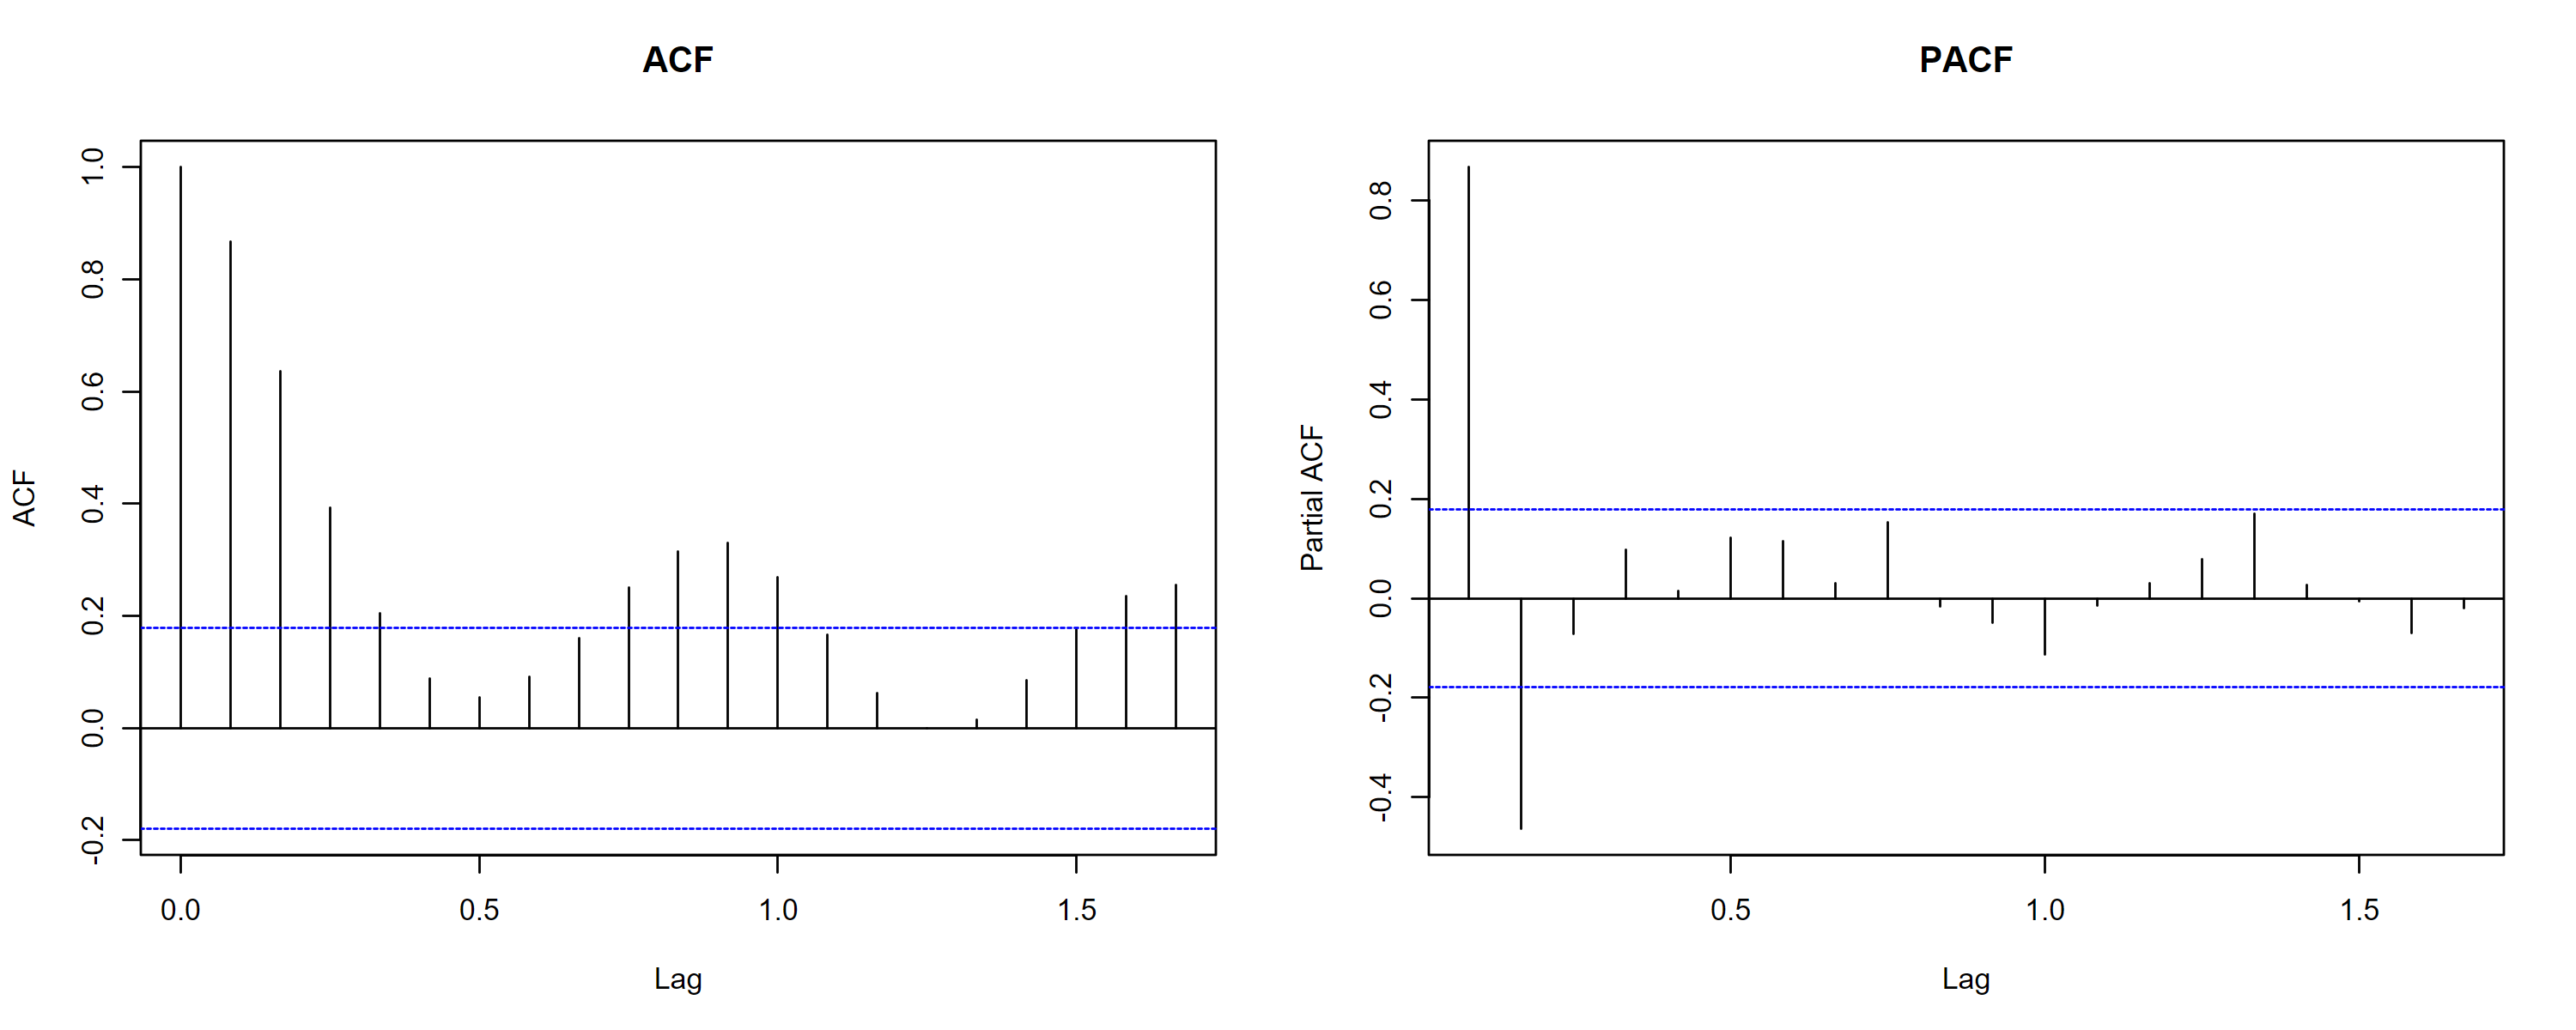

In [29]:
par(mfrow = c(1, 2))
acf(papa_l, main = "ACF", plot = TRUE)
pacf(papa_l, main = "PACF", plot = TRUE)

También se detecta cierta estacionalidad que intentaremos eliminar más adelante.

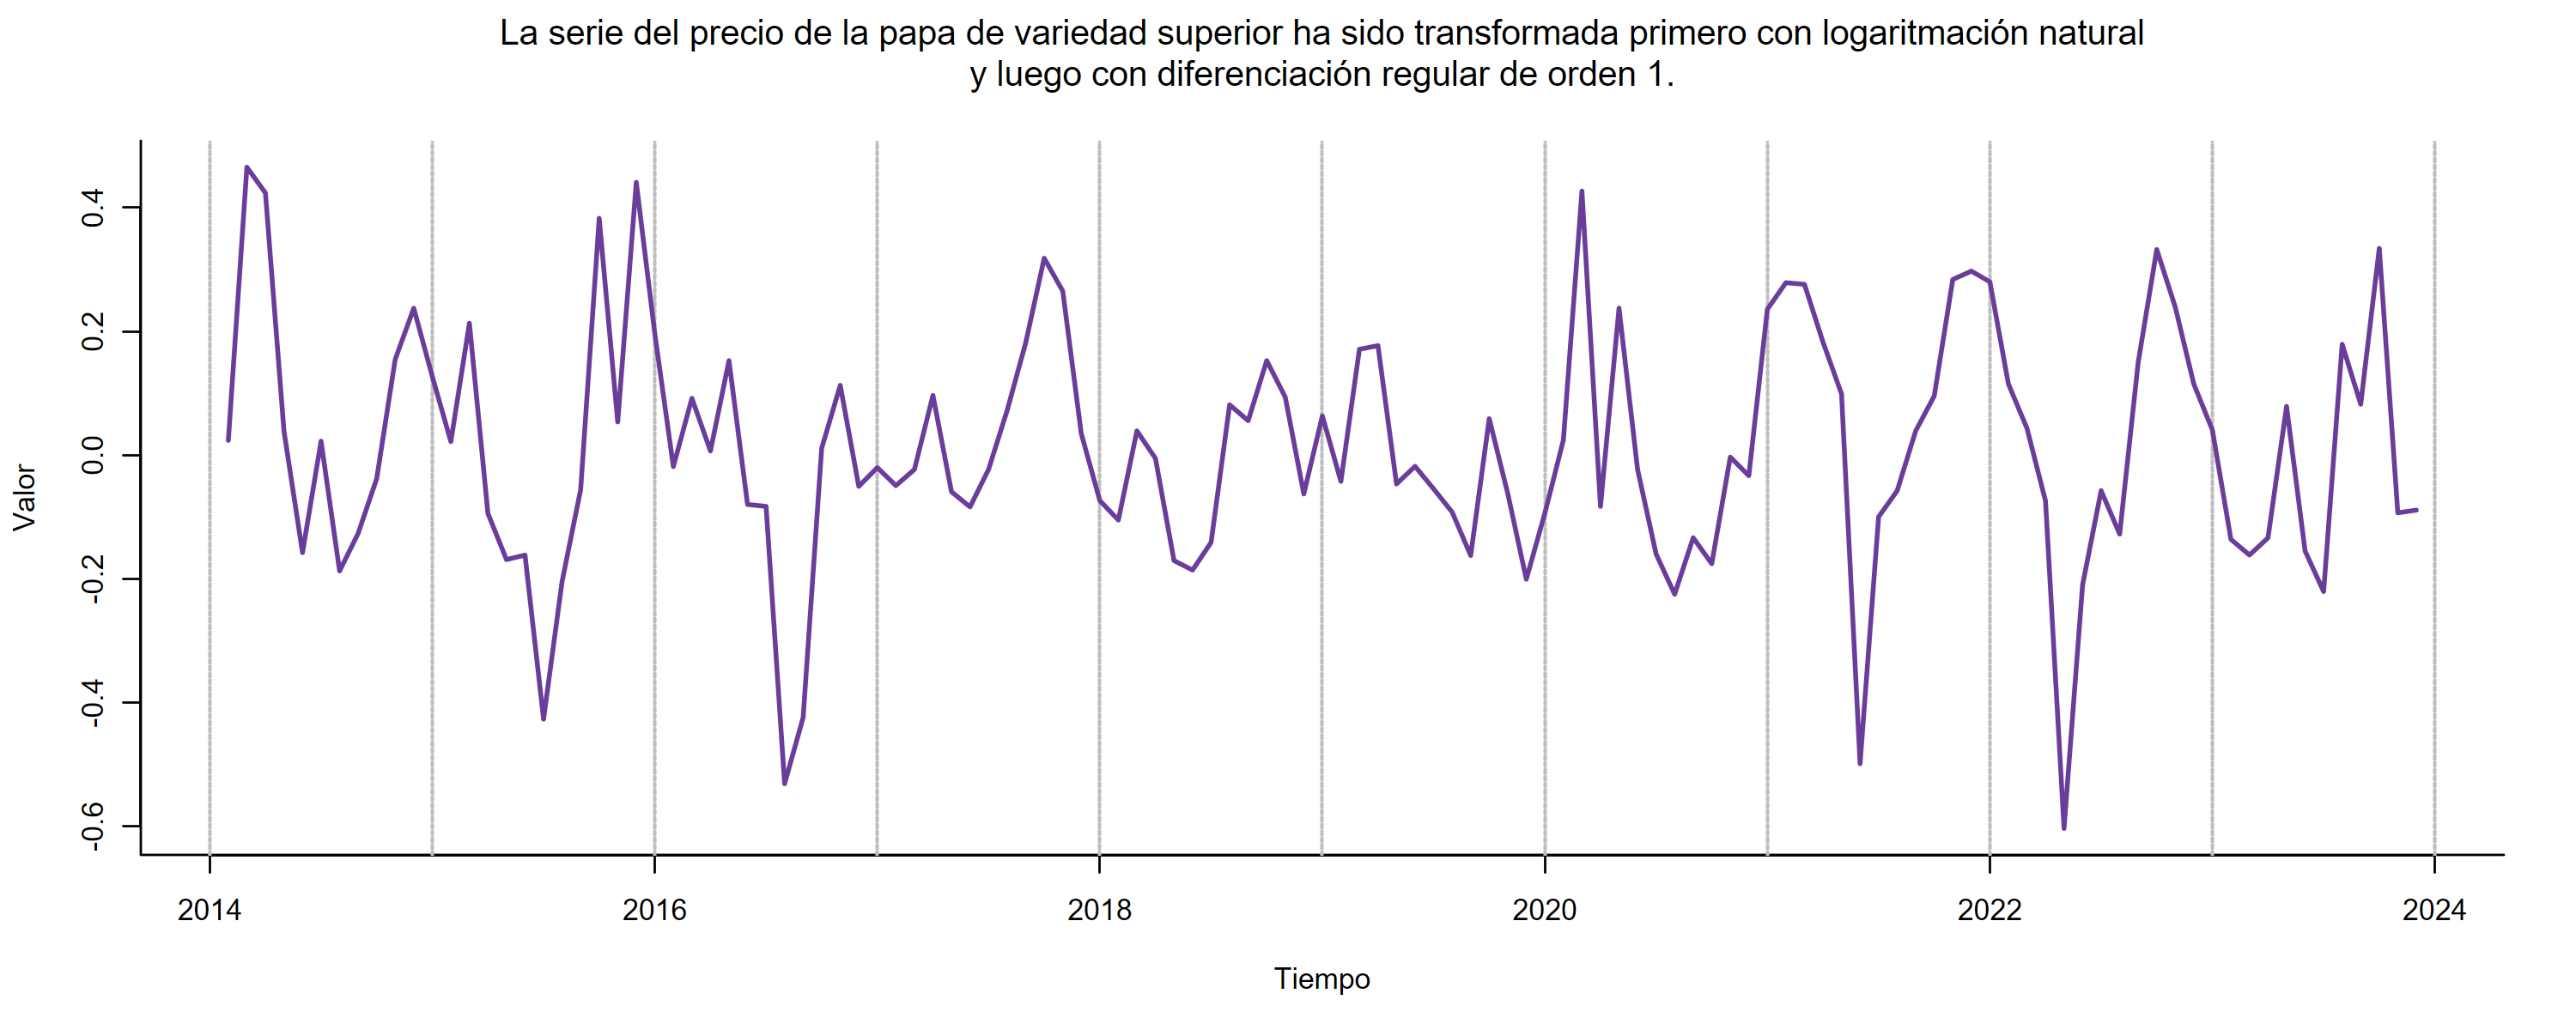

In [20]:
par(mar = c(5,4,4,2) + 0.1)
plot(diff(papa_l), ylab = 'Valor', xlab = 'Tiempo',bty = 'l',
    main = '', cex.main = 1.5, type = 'n')
mtext(side = 3, text = 'La serie del precio de la papa de variedad superior ha sido transformada primero con logaritmación natural\ny luego con diferenciación regular de orden 1.', line = 1.5, 
     cex = 1.2)
abline(v = 2014:2024, lwd = 1.5, col = 'gray', lty = 'dashed')
lines(diff(papa_l), col = color, lwd = 2)

Si revisamos de nuevo el ACF y el PACF:

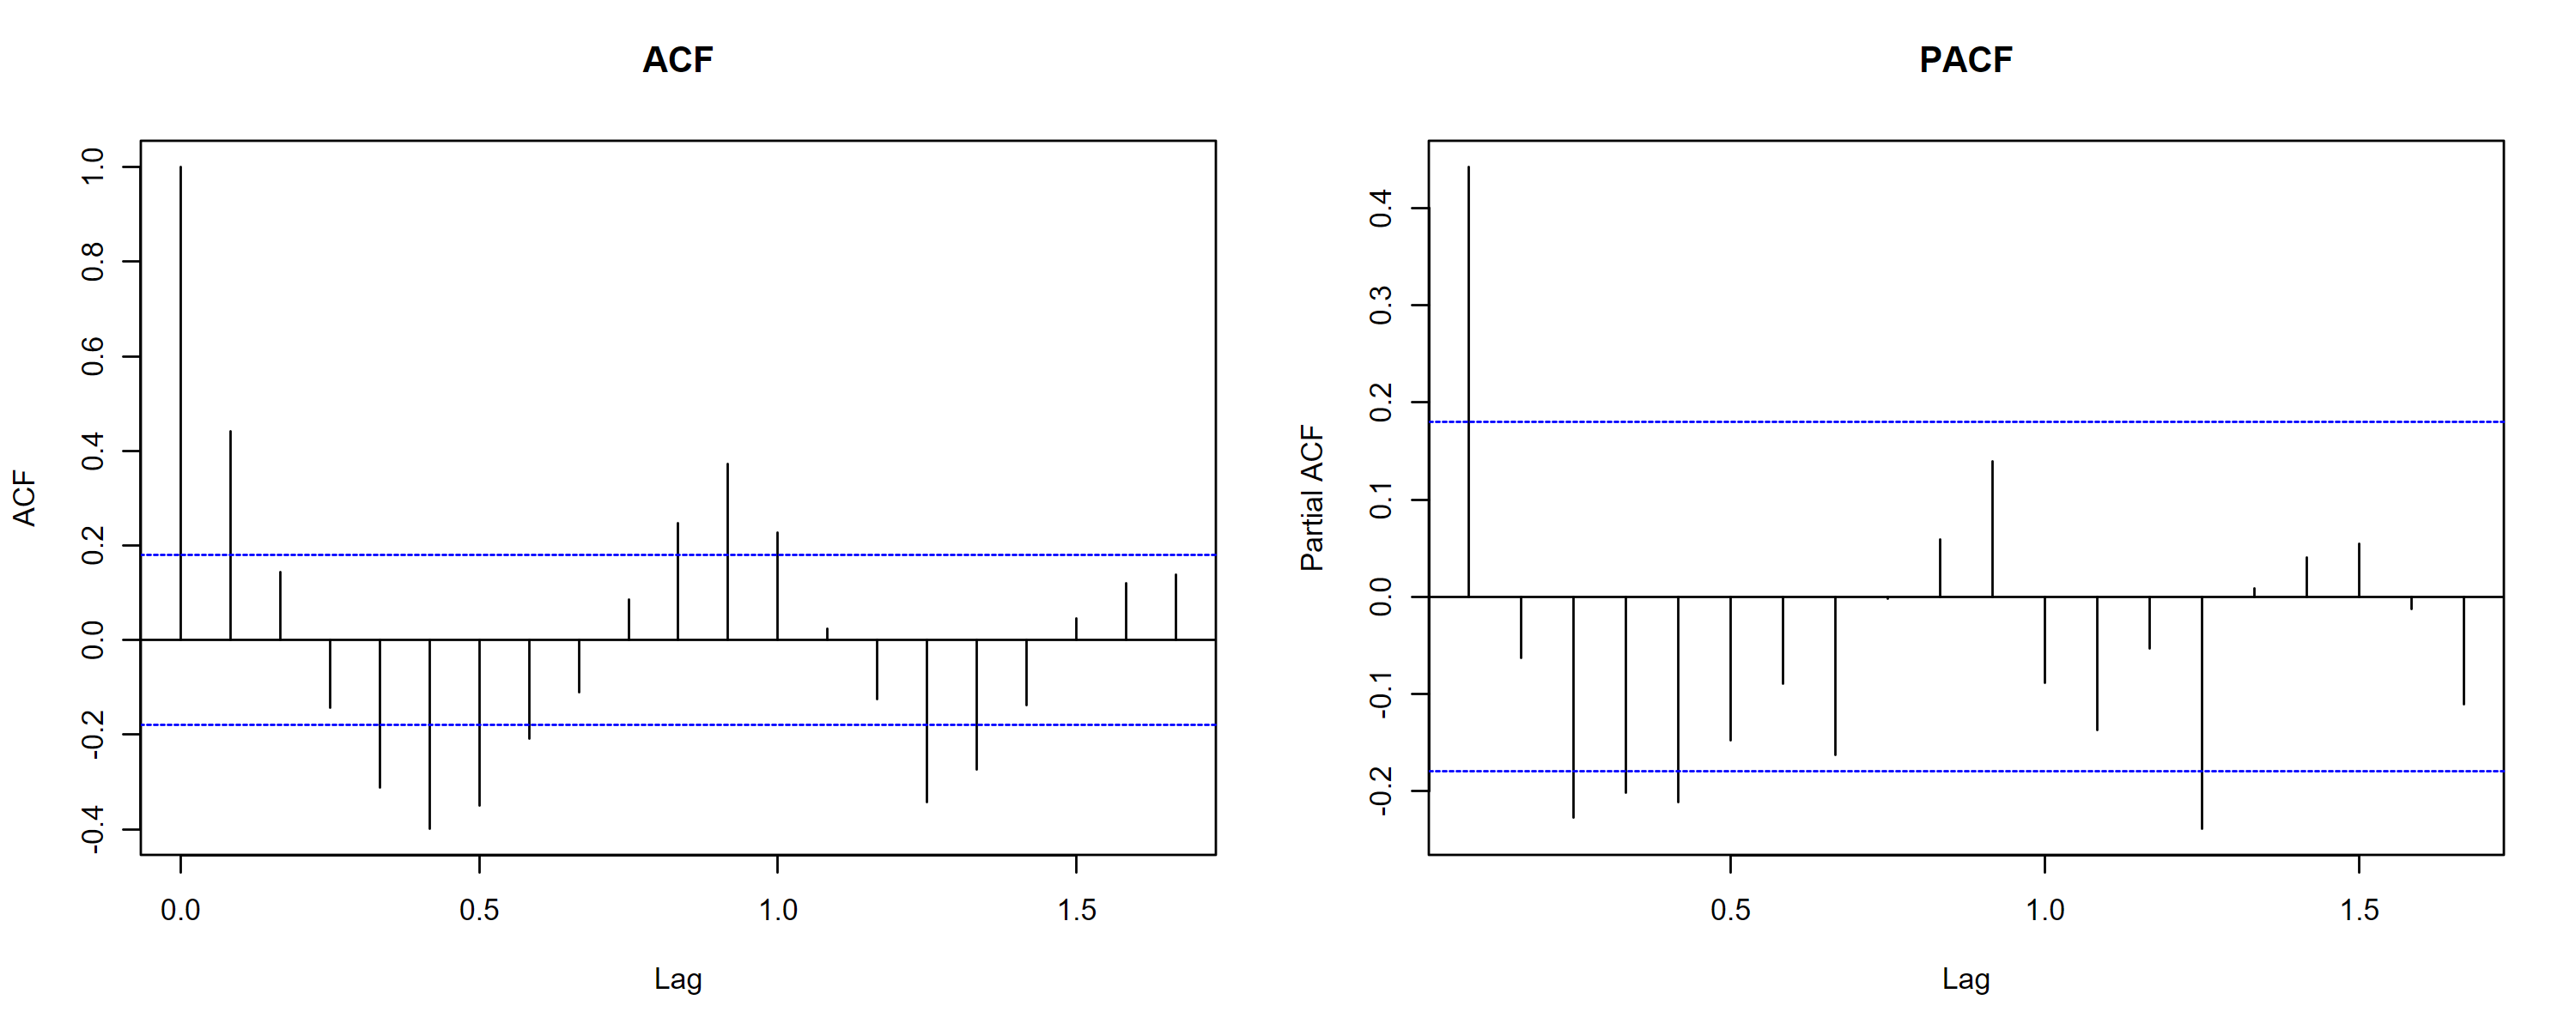

In [21]:
par(mfrow = c(1, 2))
acf(papa_ld, main = "ACF", plot = TRUE)
pacf(papa_ld, main = "PACF", plot = TRUE)

La serie no aparenta ya tendencia alguna. La primera entrada de la serie antes de la diferenciación es:

In [22]:
primero = papa[1]
primero

[1] 453

Y las pruebas ya todas presentan evidencias de estacionalidad:

In [23]:
tseries::adf.test(papa_ld)
tseries::kpss.test(papa_ld)
tseries::pp.test(papa_ld)


	Augmented Dickey-Fuller Test

data:  papa_ld
Dickey-Fuller = -7, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary



	KPSS Test for Level Stationarity

data:  papa_ld
KPSS Level = 0.03, Truncation lag parameter = 4, p-value = 0.1



	Phillips-Perron Unit Root Test

data:  papa_ld
Dickey-Fuller Z(alpha) = -63, Truncation lag parameter = 4, p-value =
0.01
alternative hypothesis: stationary


In [24]:
ndiffs(papa_ld)

[1] 0

## *3️⃣ ¿ESTACIONALIDAD?*

Intuitivamente, la serie debiere de mostrar cierto tipo de estacionalidad por el hecho de que la papa como cultivo es de ciclos (Apróximadamente cada seis meses):

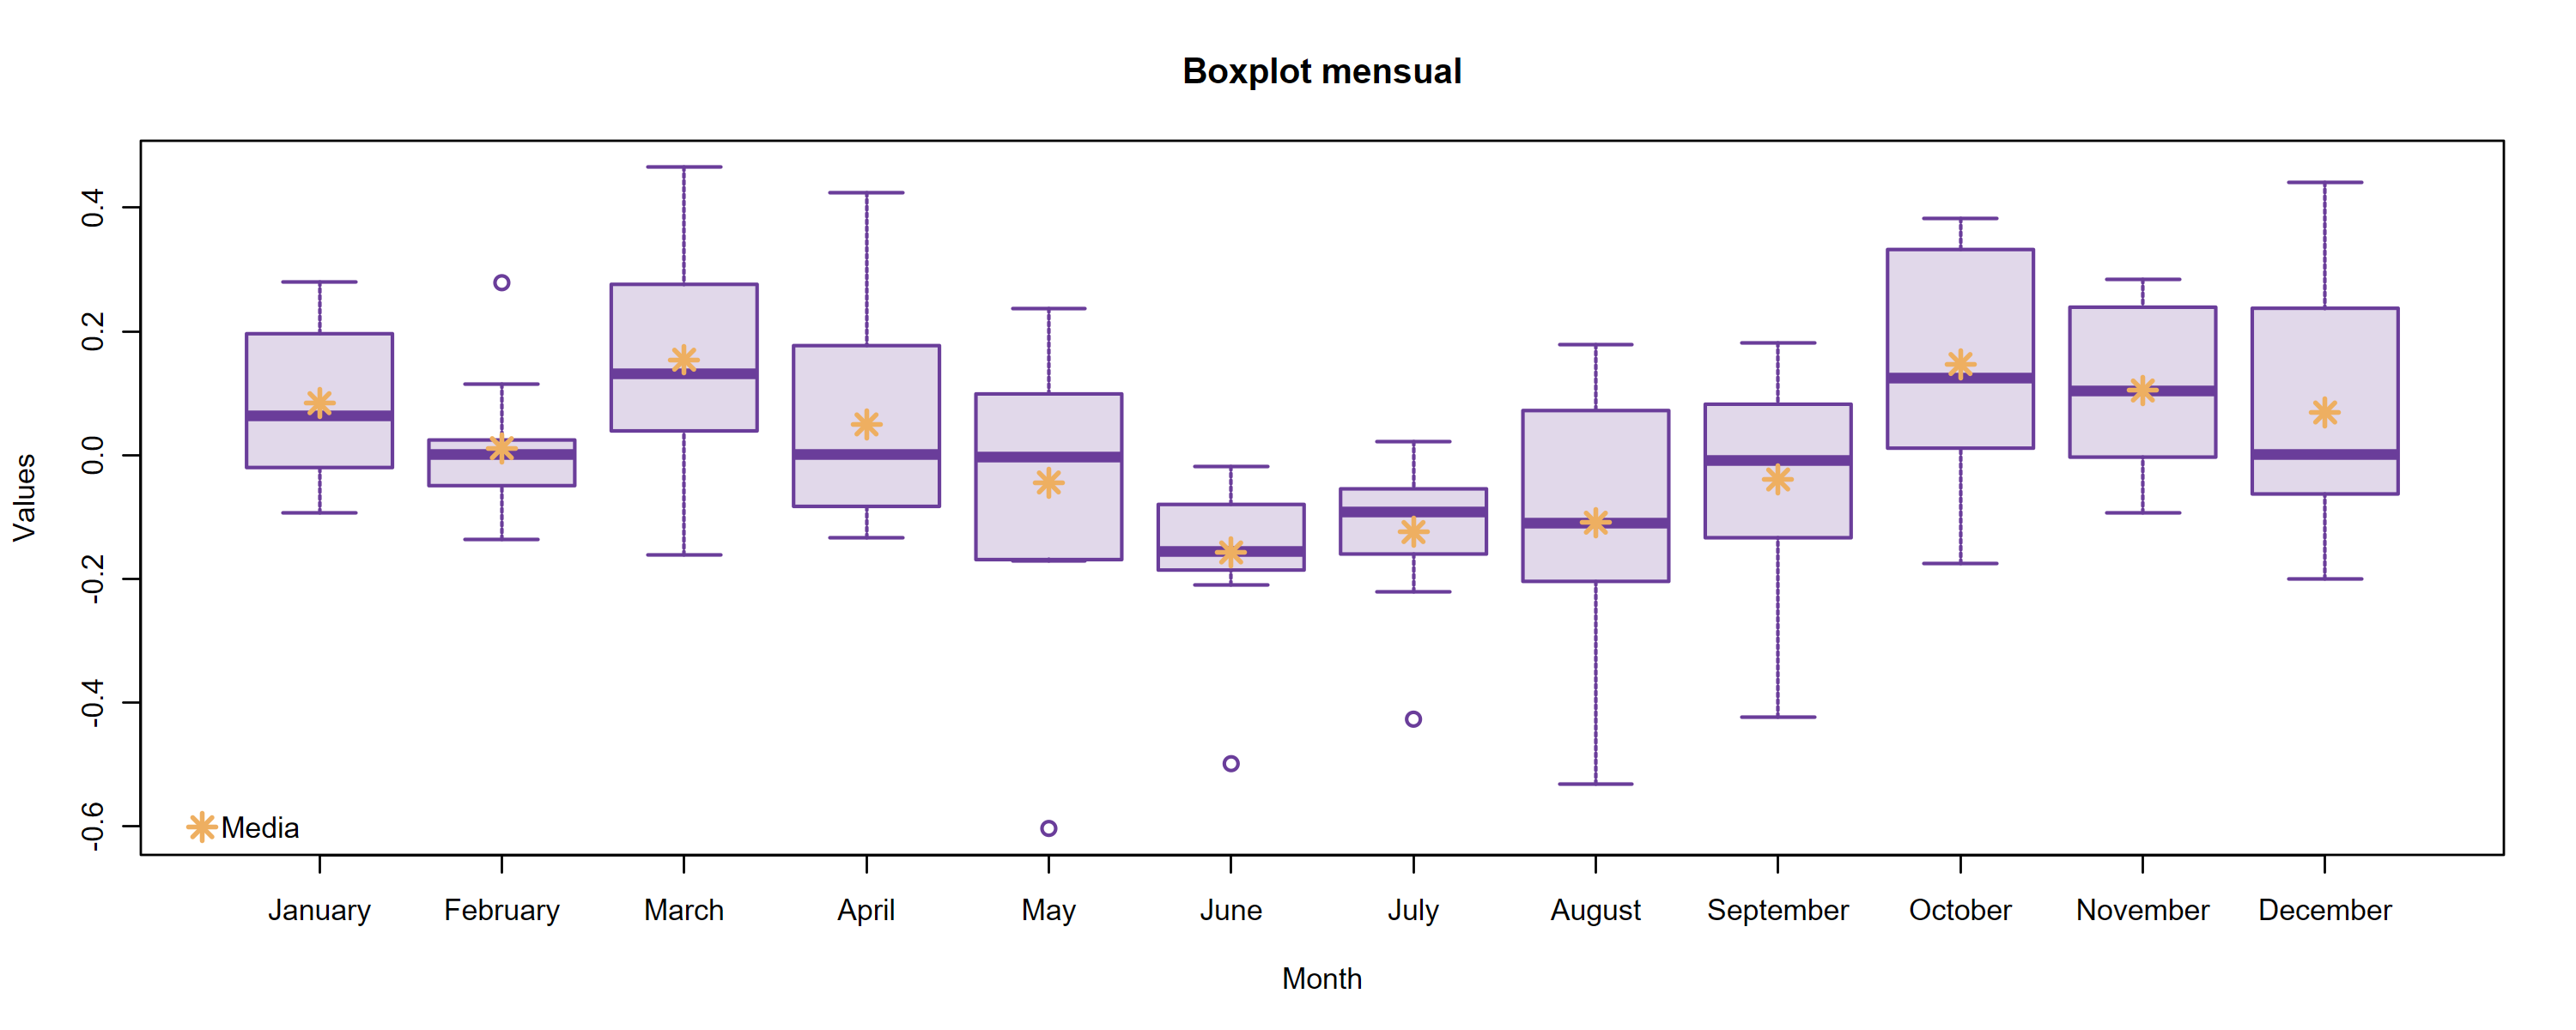

In [48]:
meses = data.frame('Valores' = as.numeric(papa_ld), month = factor(rep(month.name,10)[-1], levels = c(month.name)))
b = boxplot(meses$Valores ~ meses$month, xlab = 'Month', ylab = 'Values', 
        col = adjustcolor(color, 0.2),
        border = color, lwd = 1.5, 
       main = 'Boxplot mensual')
points(x = 1:12, y = meses |> 
                        group_by(month) |>
                        summarise(m = mean(Valores)) |>
                        pull(m),
       pch = 8, col = '#EEAf61', cex = 1.5, lwd = 2)
legend('bottomleft', legend = 'Media', pch = 8, col = '#EEAf61', bty = 'n', pt.cex = 1.5, pt.lwd = 2, 
      x.intersp = 0.3)

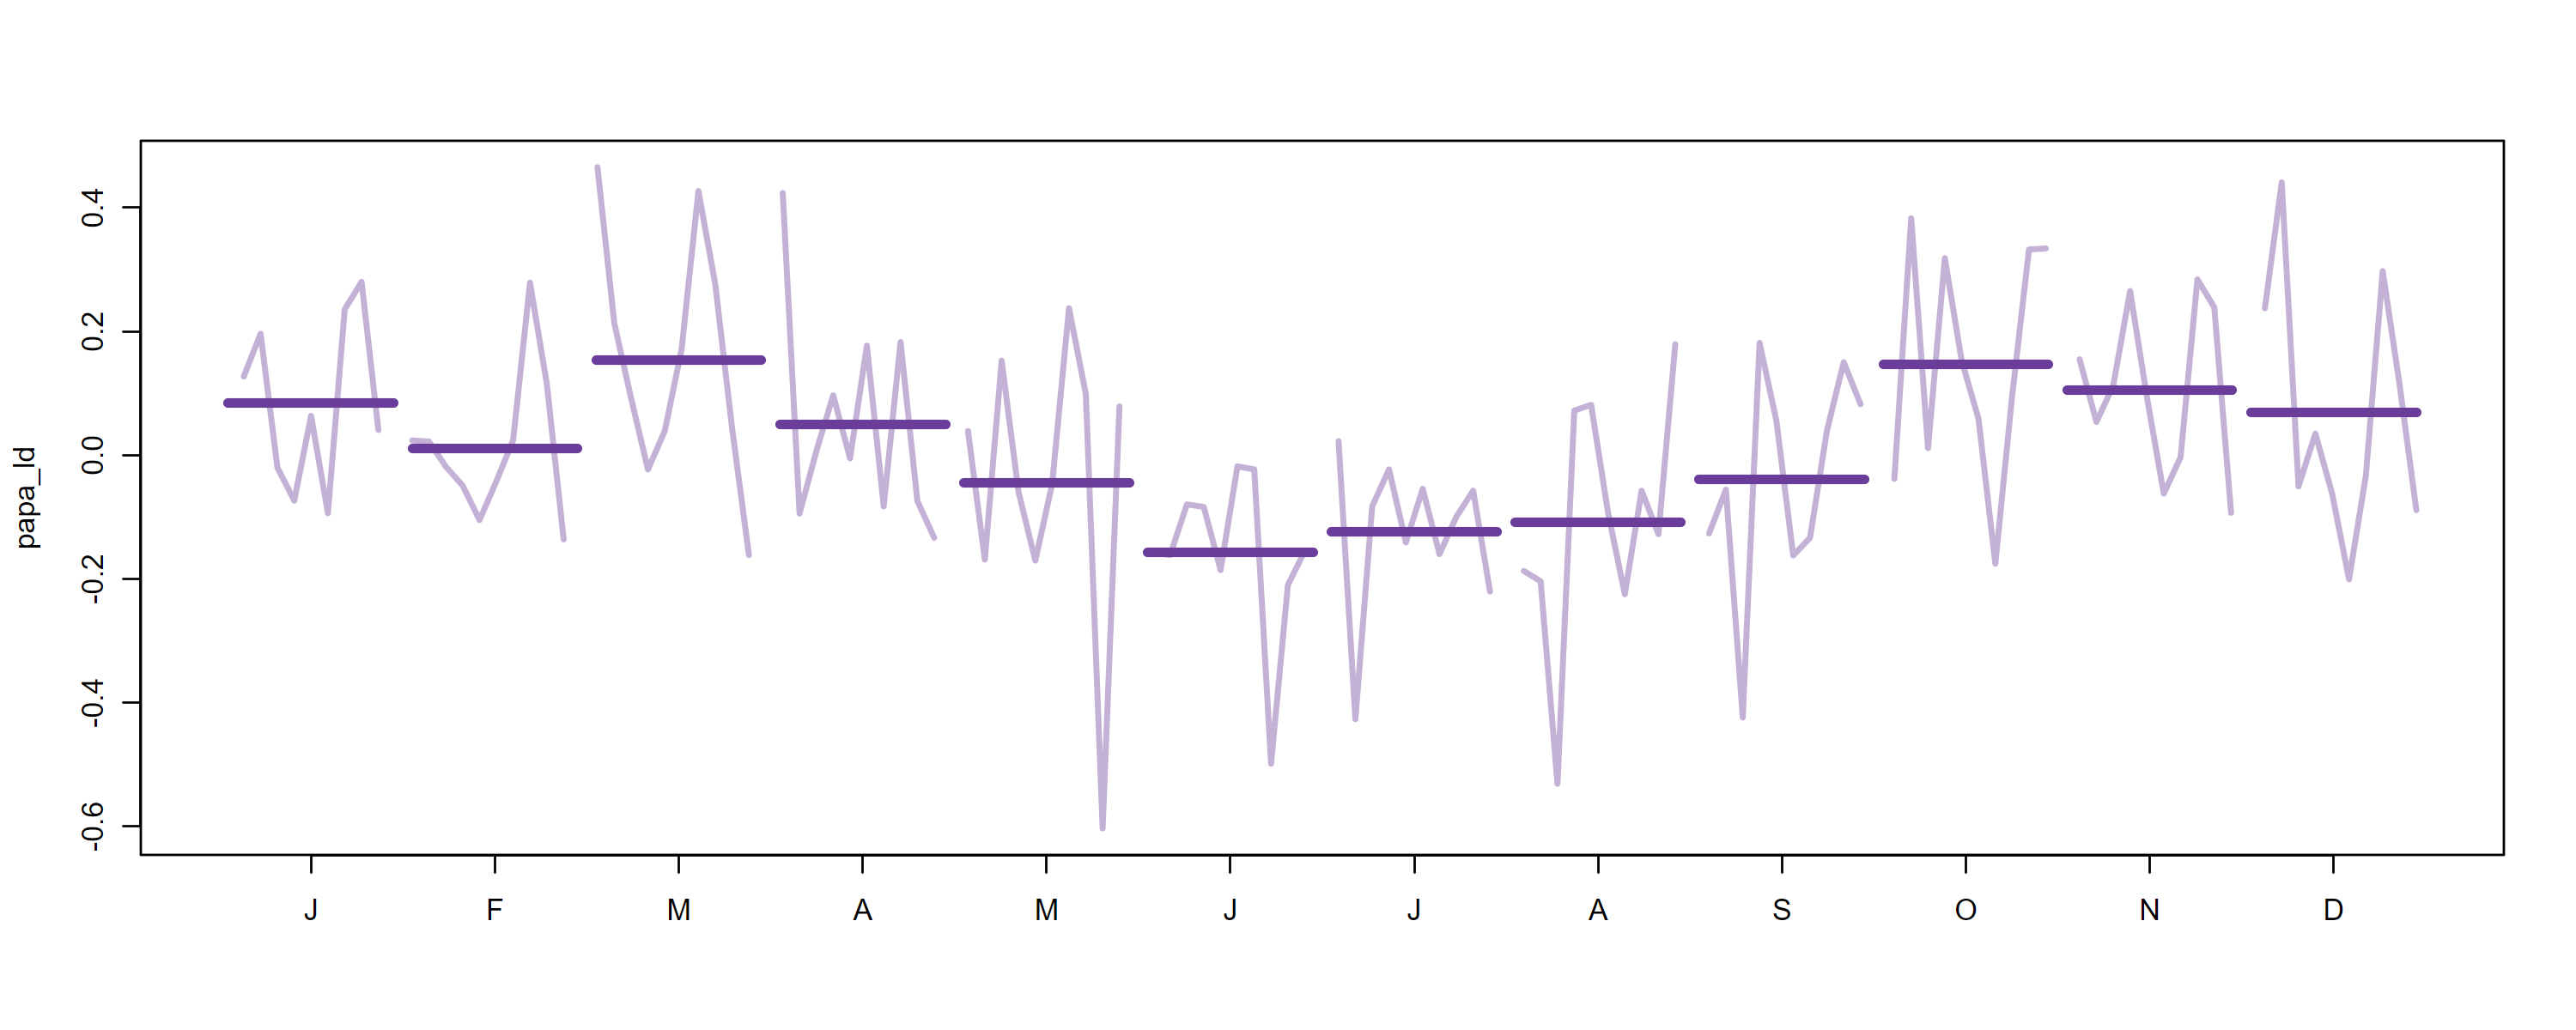

In [26]:
color1 = adjustcolor(color, 0.4)
monthplot(papa_ld, lwd = 2.5, col.base = color, col = '#6A3D9A66', lwd.base = 4)

In [27]:
nsdiffs(papa_l); nsdiffs(papa_ld)

[1] 0

[1] 0

La estacionalidad se hace evidente también en las gráficas del ACF y del PACF:

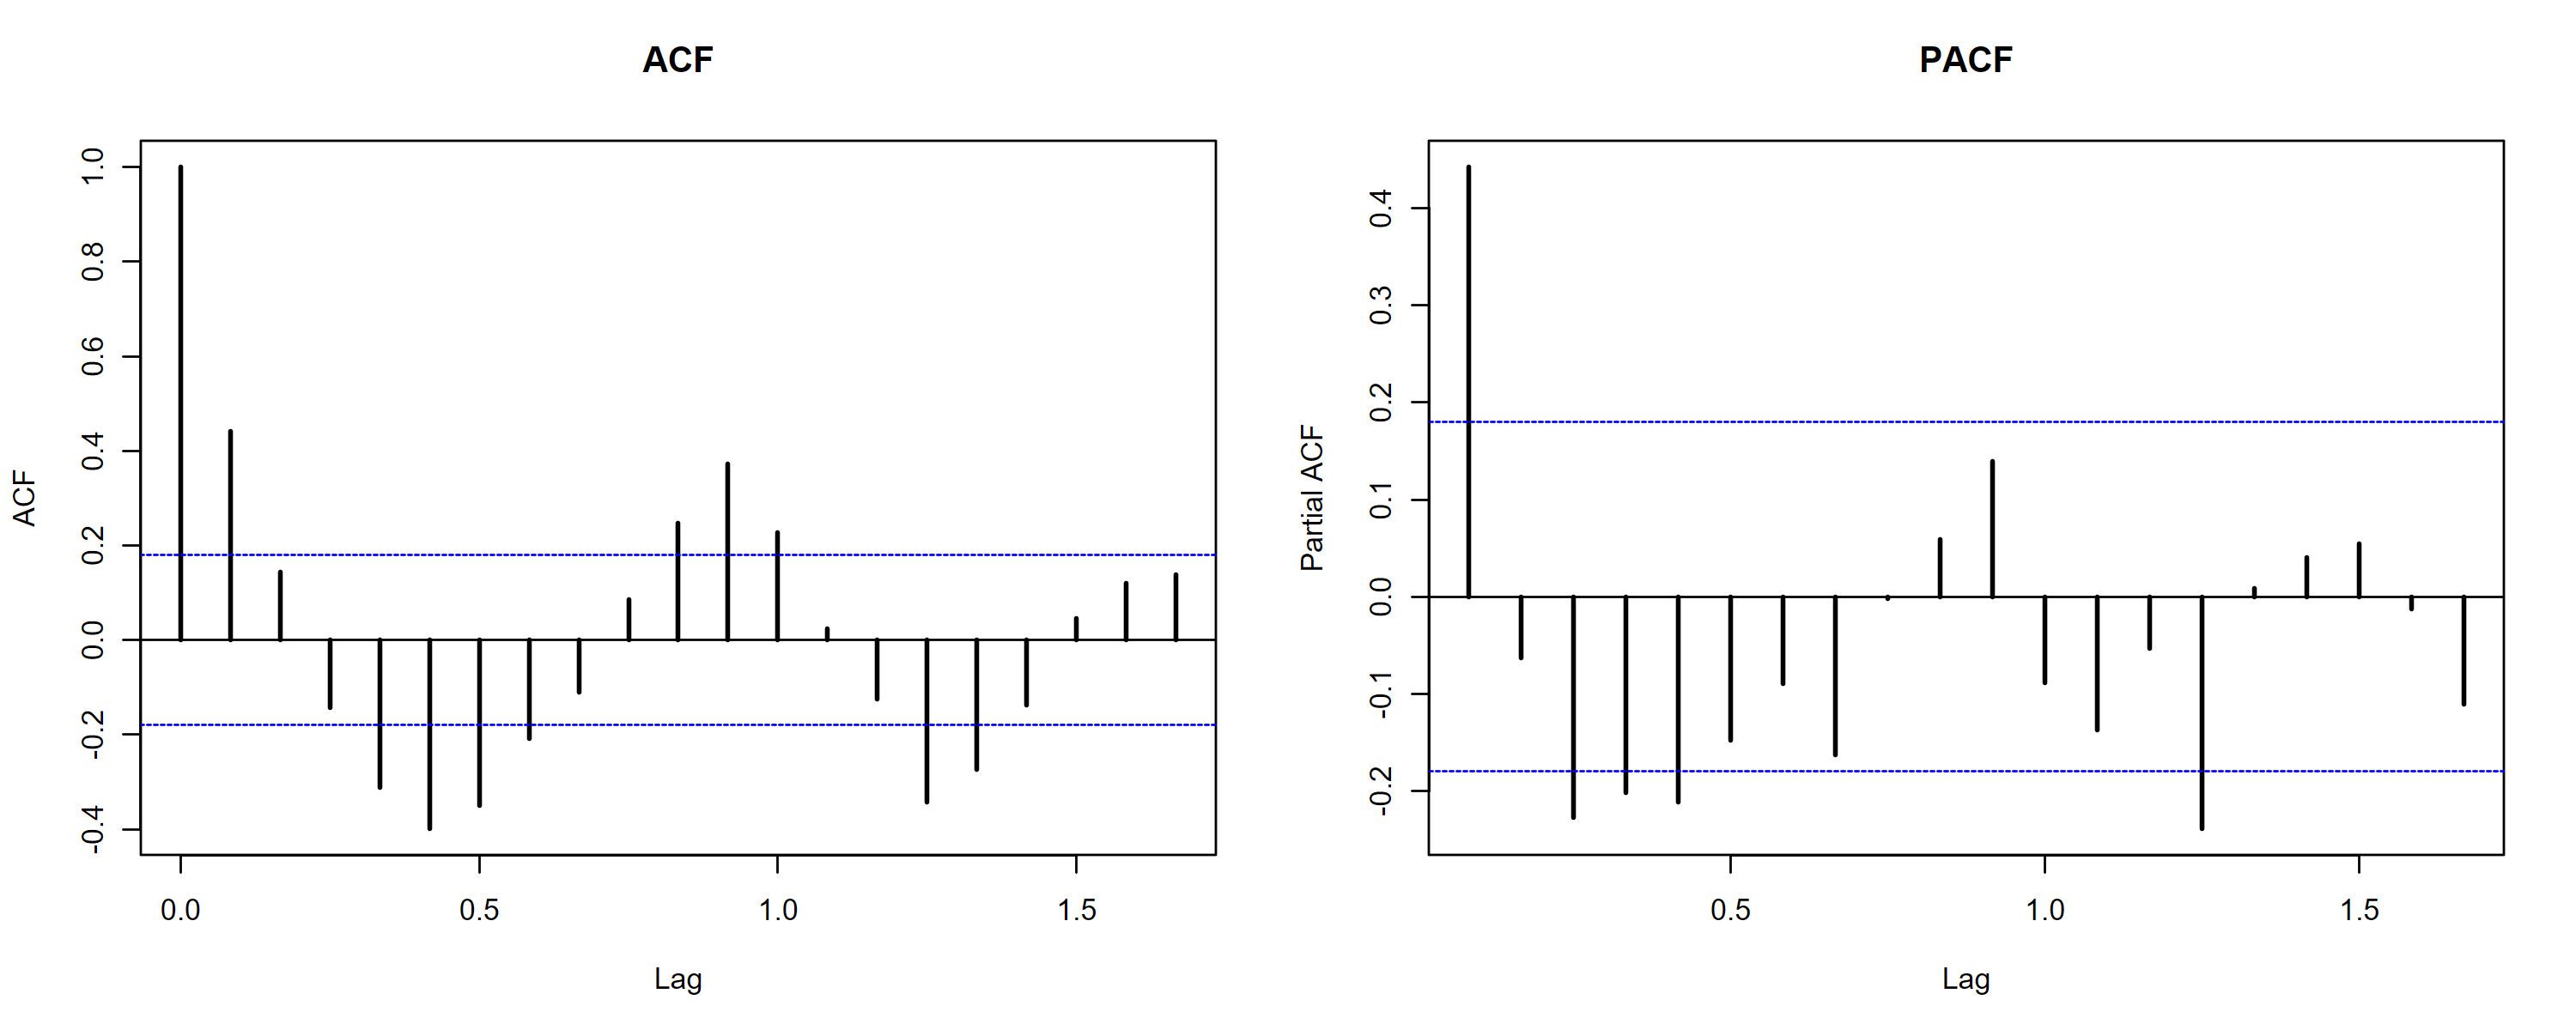

In [28]:
par(mfrow = c(1,2)) 
acf(papa_ld, cex.axis = 1, cex.lab = 1, main = 'ACF', lwd = 2)
pacf(papa_ld, cex.axis = 1, cex.lab = 1, main = 'PACF', lwd = 2)

Para dar claridad sobre la naturaleza de esta estacionalidad, intentaremos ajustar a la serie una regresión con variables dummy:

In [29]:
meses$month = as.factor(meses$month)
dummy = lm(formula = Valores ~ month - 1, data = meses)
anova(dummy)
residuos = ts(dummy$residuals, start = c(2014,2), frequency = 12)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
month,12,1.3,0.10,3.5,0.00023
Residuals,107,3.2,0.03,NA,NA


Como el modelo resulta significativo, podríamos intentar quitarle a nuestro modelo la estacionalidad mediante esta regresión:

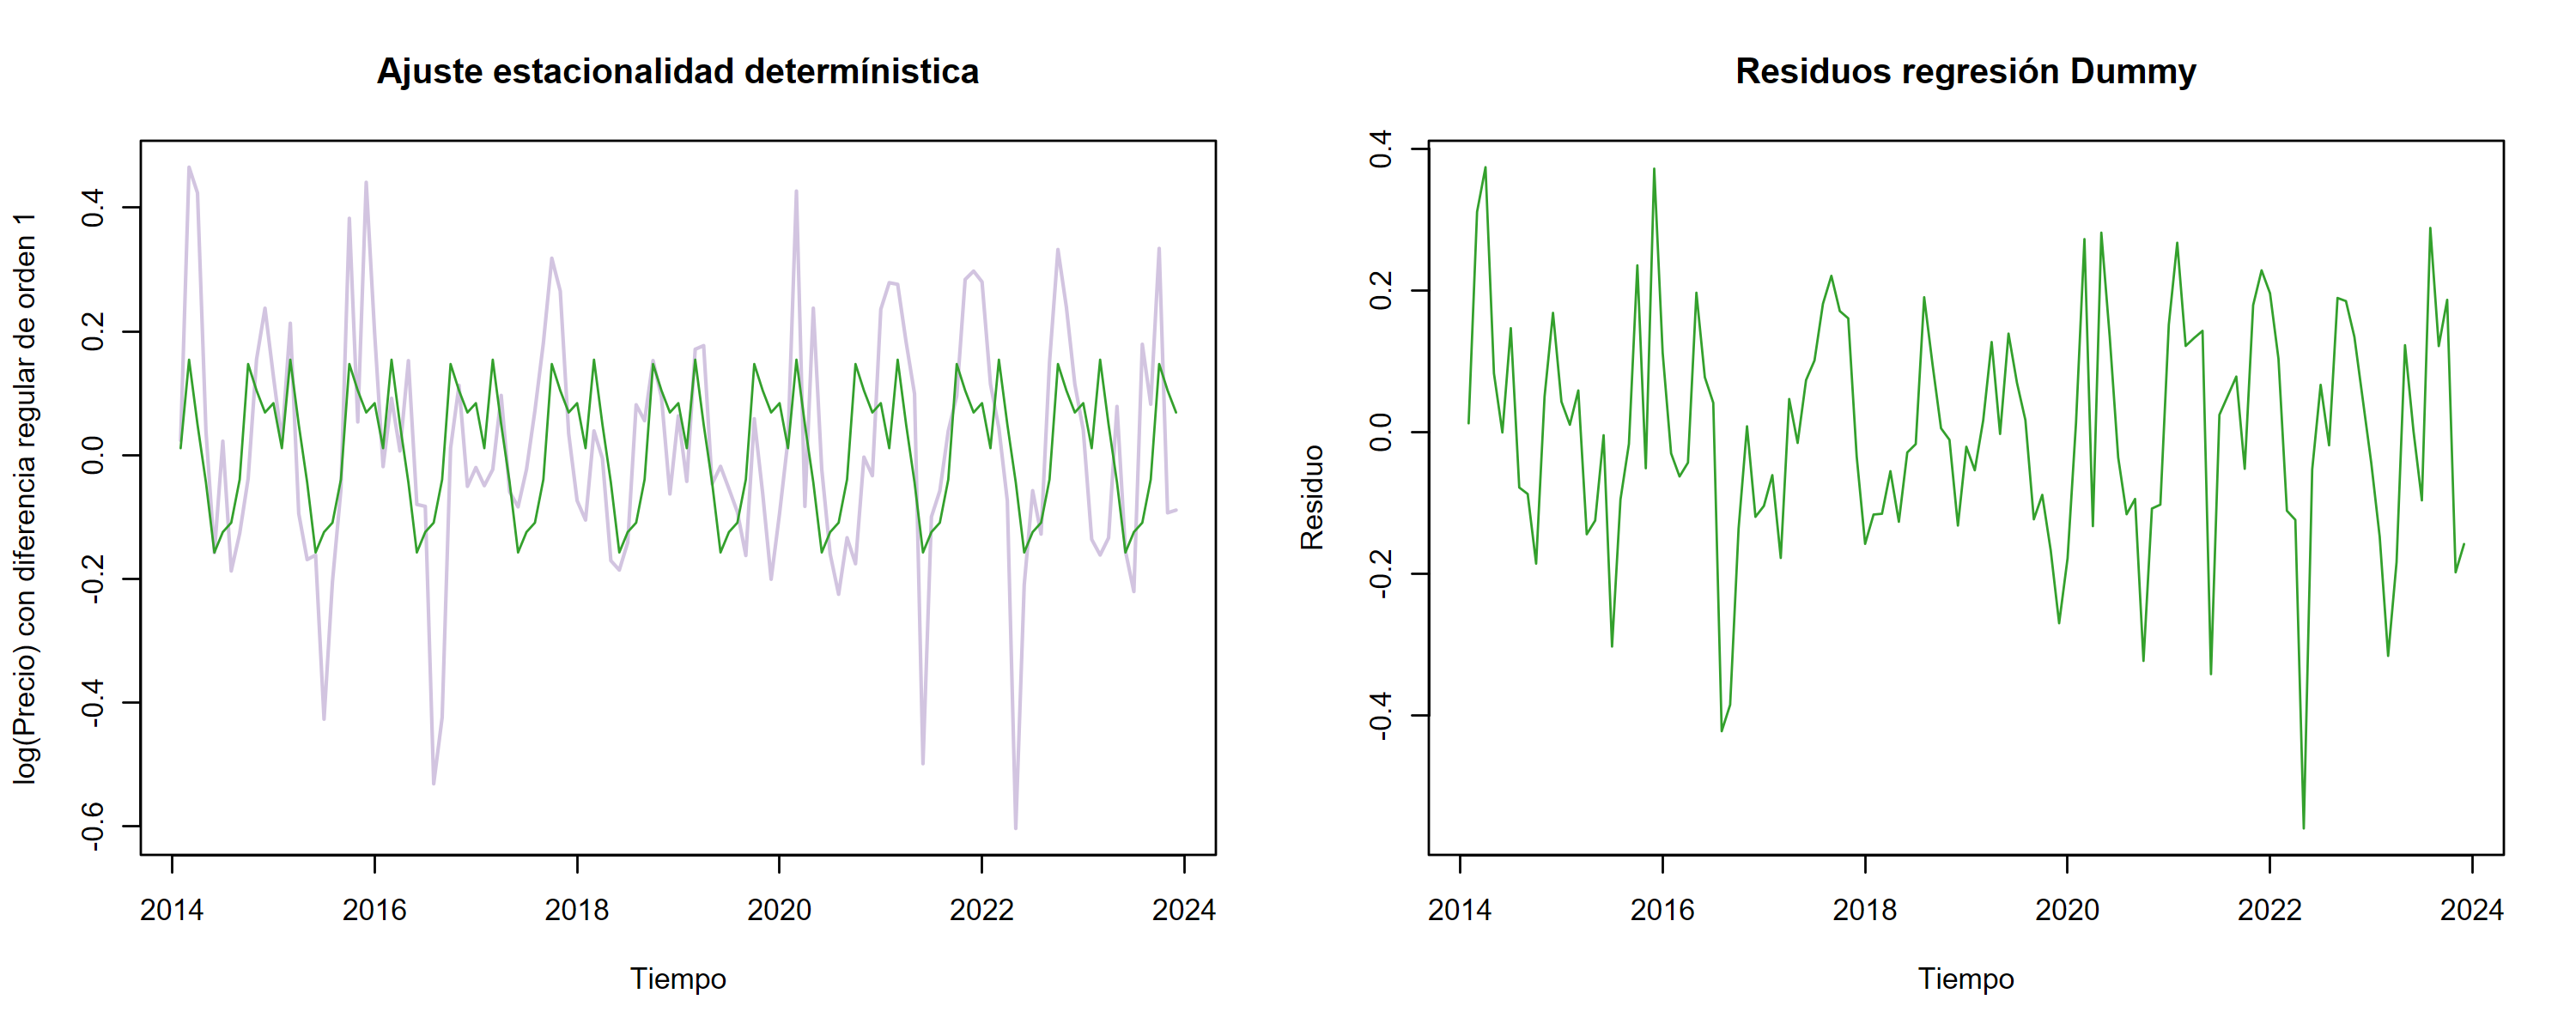

In [30]:
par(mfrow = c(1,2))
plot(papa_ld, main = 'Ajuste estacionalidad determínistica', col = adjustcolor(color, 0.3), lwd = 1.5, 
    xlab = 'Tiempo', ylab = 'log(Precio) con diferencia regular de orden 1')
lines(x = seq(from = 2014, 2024 - 1/12,by = 1/12)[-1], y = dummy$fitted.values, col = colores[4])
plot(residuos, type = 'l', col = colores[4], main = 'Residuos regresión Dummy', ylab = 'Residuo', xlab = 'Tiempo')

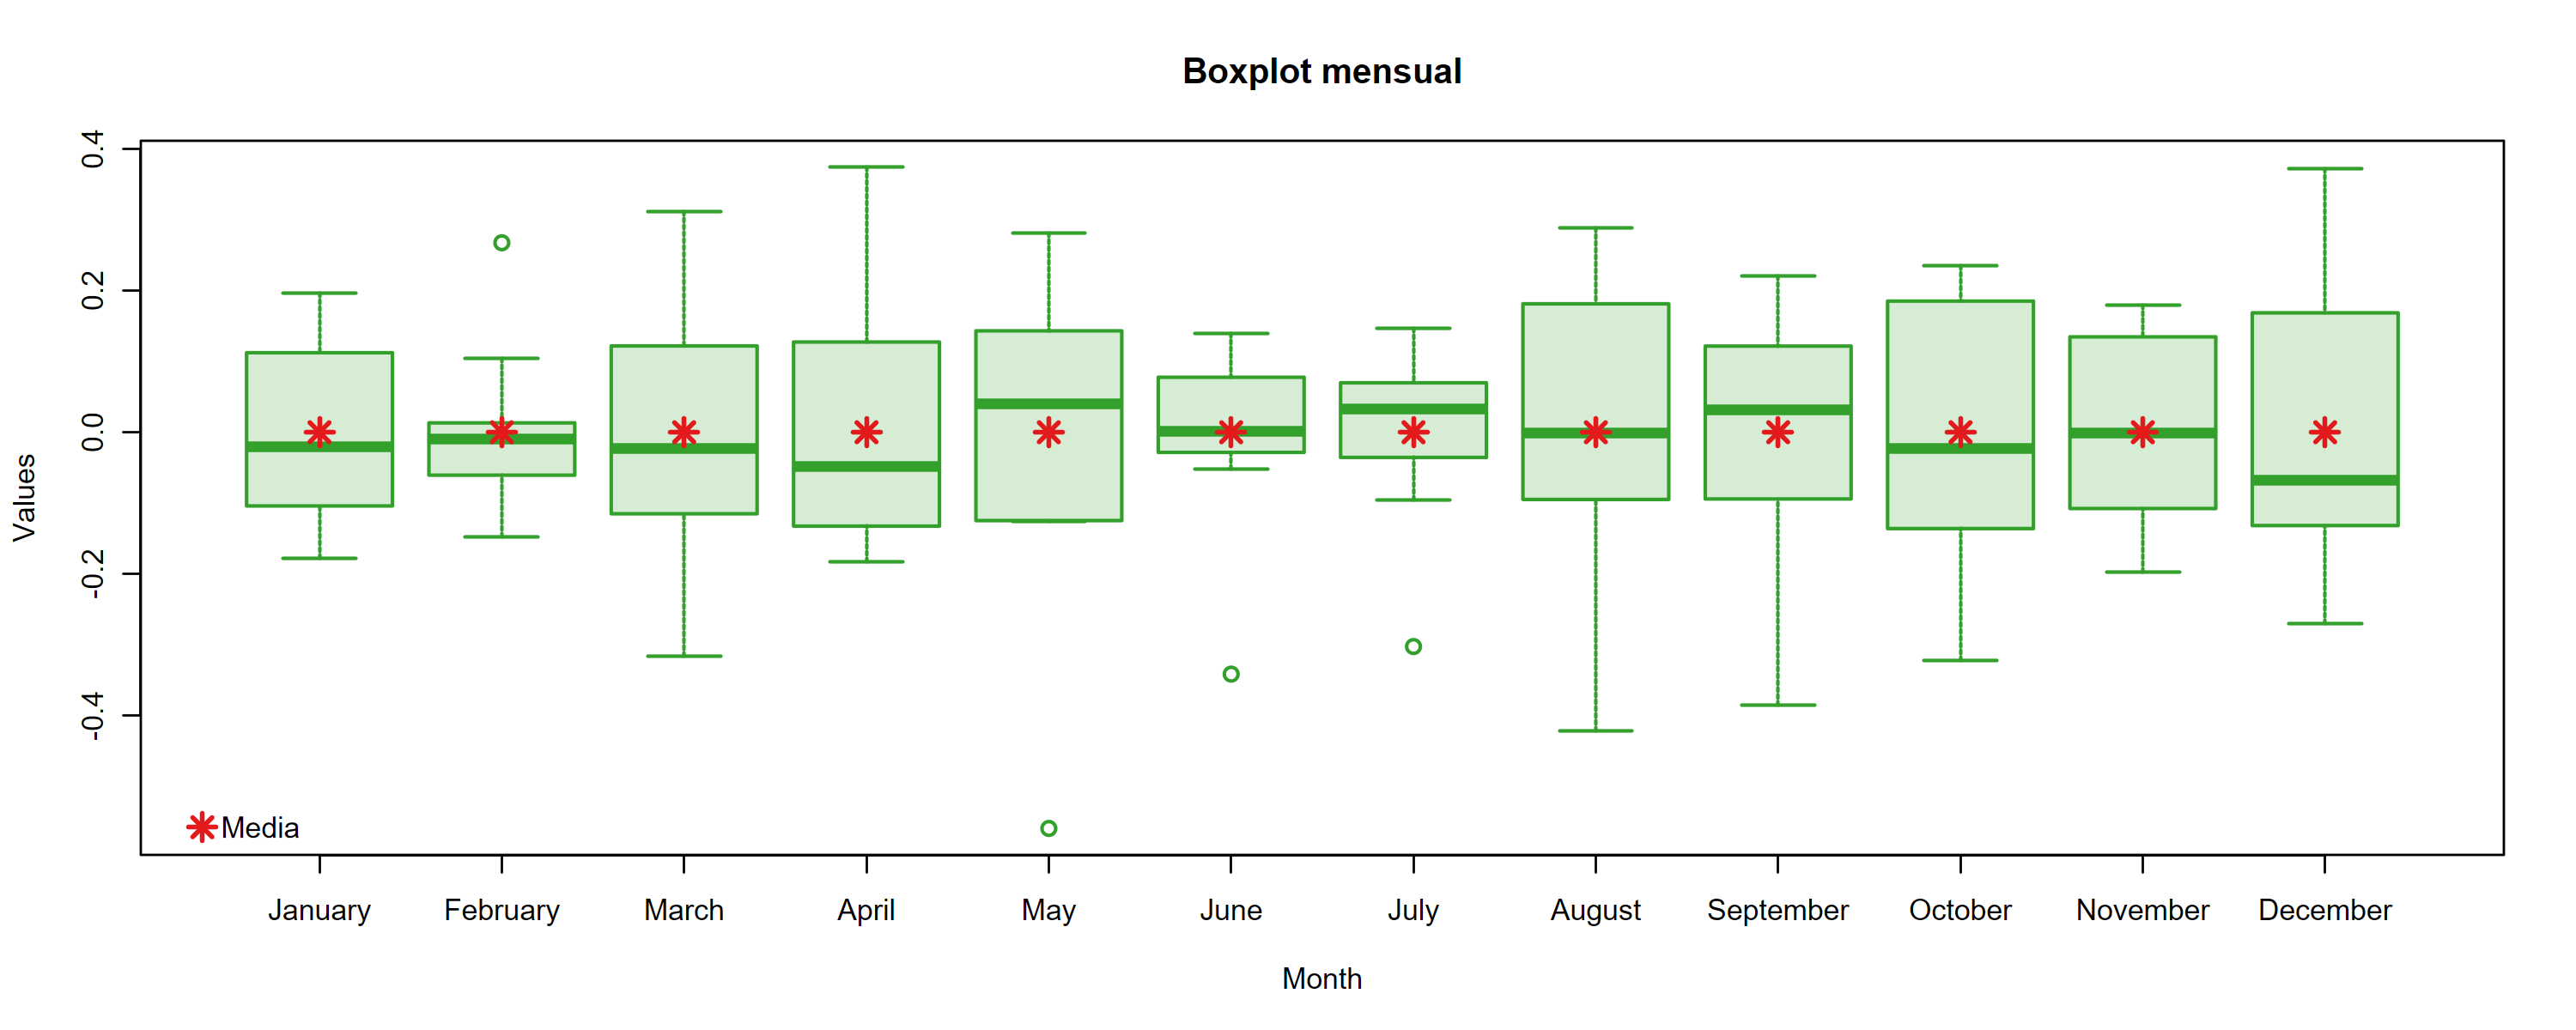

In [31]:
meses = data.frame('Valores' = as.numeric(residuos), month = factor(rep(month.name,10)[-1], levels = c(month.name)))
b = boxplot(meses$Valores ~ meses$month, xlab = 'Month', ylab = 'Values', 
        col = adjustcolor(colores[4], 0.2),
        border = colores[4], lwd = 1.5, 
       main = 'Boxplot mensual')
points(x = 1:12, y = meses |> 
                        group_by(month) |>
                        summarise(m = mean(Valores)) |>
                        pull(m),
       pch = 8, col = colores[6], cex = 1.5, lwd = 2)
legend('bottomleft', legend = 'Media', pch = 8, col = colores[6], bty = 'n', pt.cex = 1.5, pt.lwd = 2, 
      x.intersp = 0.3)

Si bien es cierto que el ajuste con variables Dummy resulta en un modelo significativo y que al menos en términos de la media la serie parece haberse estabilizado, también es cierto que los residuales parecen tener cierta estacionalidad aún:

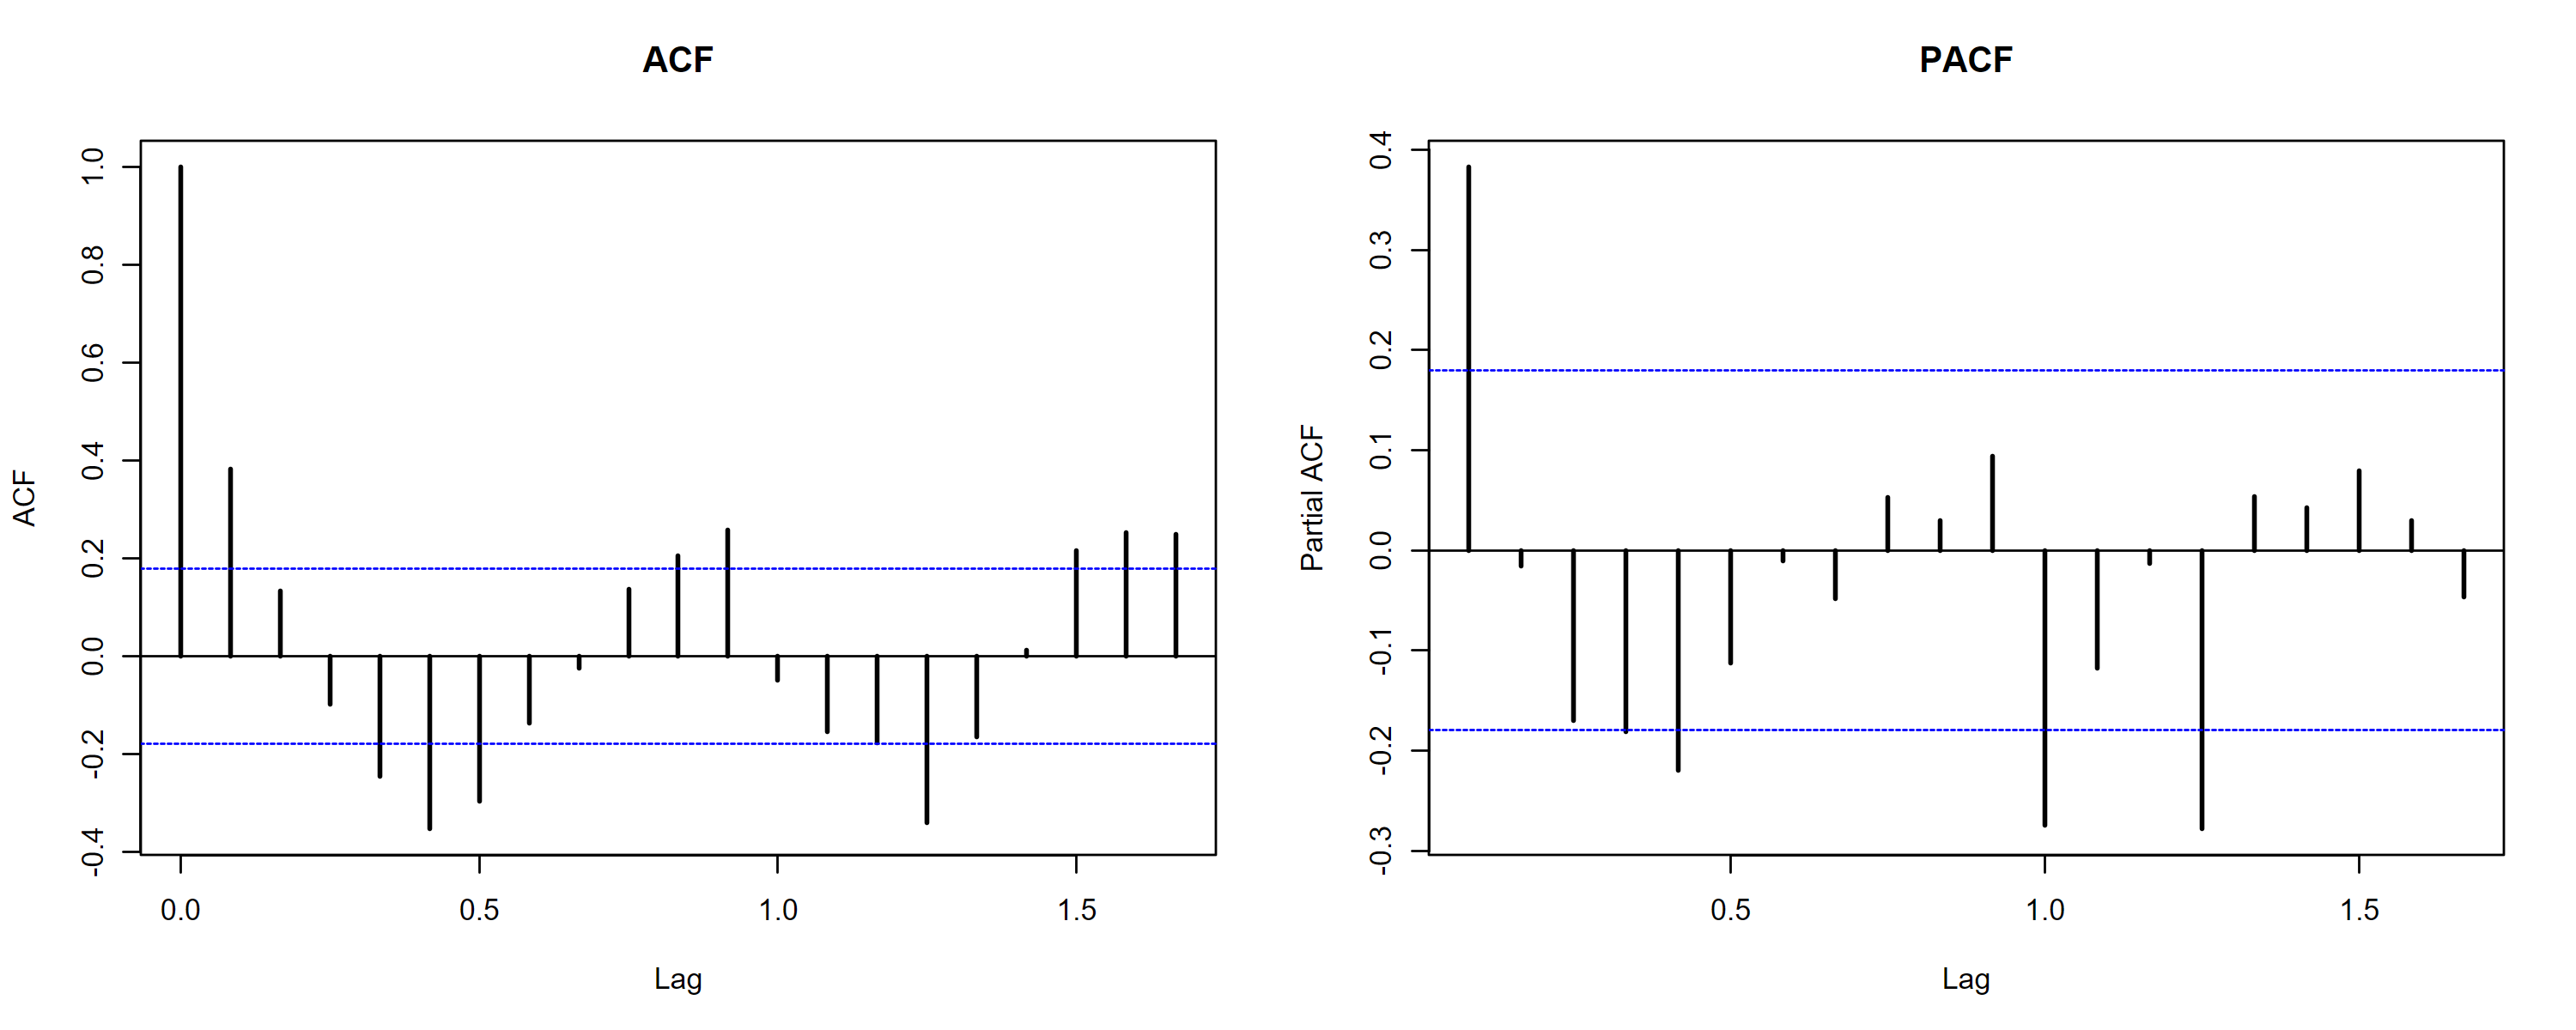

In [32]:
par(mfrow = c(1,2)) 
acf(residuos, cex.axis = 1, cex.lab = 1, main = 'ACF', lwd = 2)
pacf(residuos, cex.axis = 1, cex.lab = 1, main = 'PACF', lwd = 2)

Por lo que podríamos inclinarnos por una estacionalidad de tipo estocástica en cambio de determínistica.

In [33]:
papa_lds = residuos

Si utilizamos diferenciación estacional:

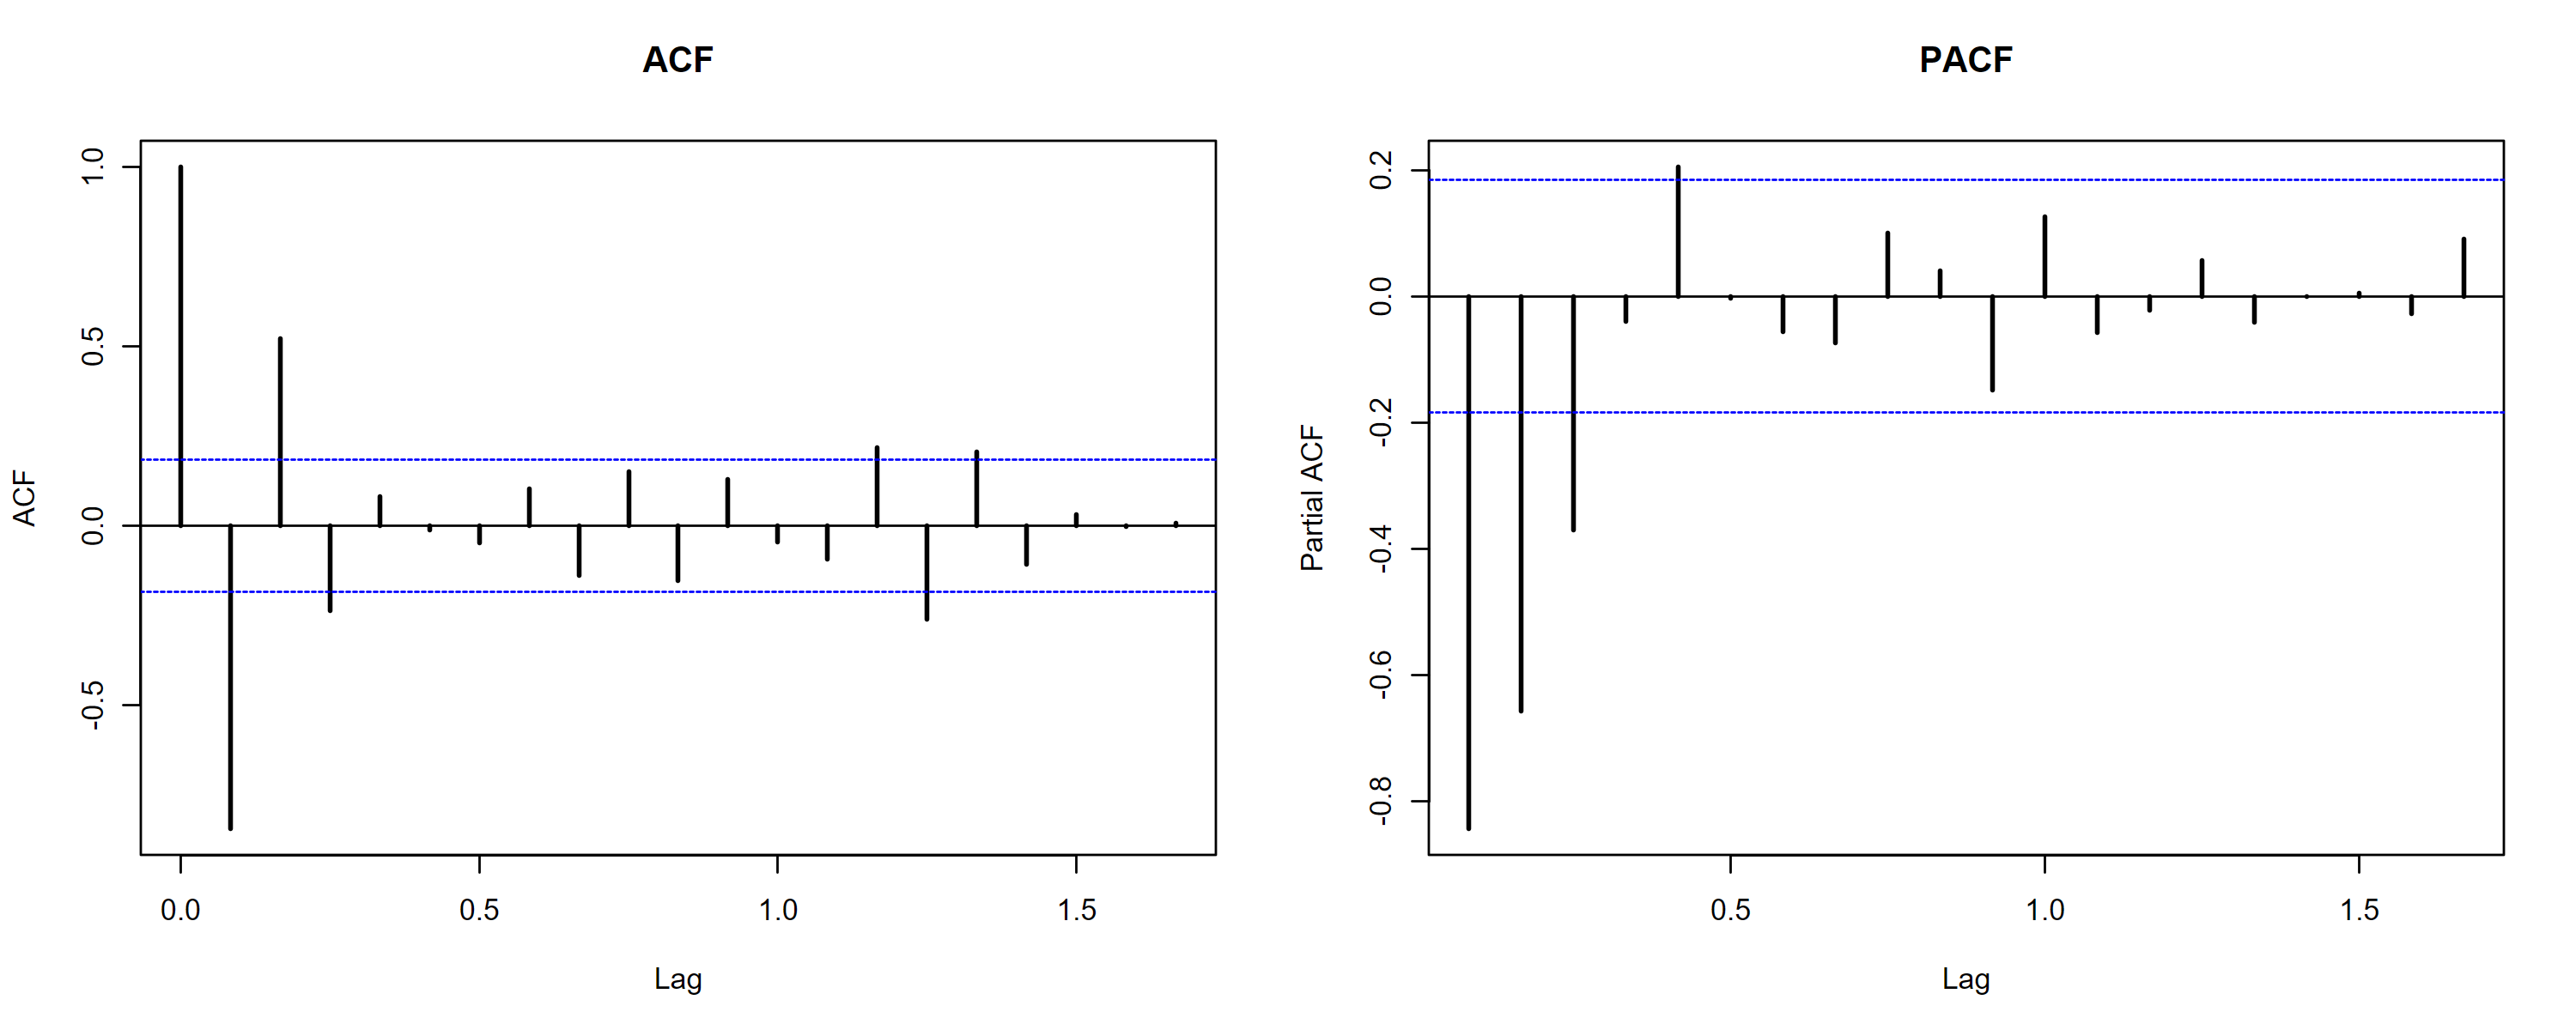

In [34]:
par(mfrow = c(1,2)) 
acf(diff(papa_ld, lag = 1, differences = 6), cex.axis = 1, cex.lab = 1, main = 'ACF', lwd = 2)
pacf(diff(papa_ld, lag = 1, differences = 6), cex.axis = 1, cex.lab = 1, main = 'PACF', lwd = 2)

In [35]:
papa_ldd = diff(papa_ld, lag = 1, differences = 6)

## *4️⃣ ¿ESTACIONARIDAD?*

Para conocer si una serie es estacionaria o no, usualmente se utiliza el test de Dickey Fuller:

In [36]:
tseries::adf.test(papa_ldd)


	Augmented Dickey-Fuller Test

data:  papa_ldd
Dickey-Fuller = -15, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


Como se comento antes, la serie no muestra evidencia de no estacionaridad mediante el test de Dickey Fuller. Ni utilizando otras pruebas:

In [37]:
tseries::kpss.test(papa_ldd)


	KPSS Test for Level Stationarity

data:  papa_ldd
KPSS Level = 0.04, Truncation lag parameter = 4, p-value = 0.1


In [38]:
tseries::pp.test(papa_ldd)


	Phillips-Perron Unit Root Test

data:  papa_ldd
Dickey-Fuller Z(alpha) = -197, Truncation lag parameter = 4, p-value =
0.01
alternative hypothesis: stationary


Y en lo que se refiere a estacionalidad, tampoco tenemos evidencia de que la serie necesite ningún cambio o diferenciación en lo que a diferenciación se refiere:

In [39]:
nsdiffs(papa_ldd)
ndiffs(papa_ldd)

[1] 0

[1] 0

Por esta razón guardamos los objetos `papa`, `papa_l`, `papa_ld`, `papa_lds` y `papa_ldd` para posterior implementación de modelos.

In [40]:
save(list = c('papa', 'papa_l', 'papa_ld', 'papa_lds', 'papa_ldd'), file = 'papa.RData') 